# Identifying potential Bot or Paid reviewers using Amazon customer review data using Network Analysis
**By: SLT11A**
* Abel Johua Cruzada
* James Gonzales

# Executive Summary

In [197]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re

import networkx as nx
import networkx_abel as nxa

from matplotlib.gridspec import GridSpec

from networkx_abel.NodeSizeScaler import NodeSizeScaler
from networkx_abel.NetworkProperties import NetworkProperties
from networkx_abel.communities.LouvainMethod import LouvainMethod
from networkx_abel.communities.HierarchicalClustering import (
    HierarchicalClustering)

from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.spatial.distance import euclidean, cosine
from collections import Counter
from itertools import chain

from matplotlib.lines import Line2D
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from tqdm.notebook import tqdm
import warnings

In [2]:
aws_palette = ['#232f3e', '#e47911', '#007eb9', '#48a3c6', '#37475a']
sns.set_palette(palette=aws_palette)

# Introduction

The growth of online-selling platforms emphasized the power of influence of product reviews in shaping the perceptions about a product. People are swayed to buy a product when observed to have several positive ratings, while some are discouraged when the product ratings are negative. With this, the product frameworks could be helpful for customers to have confidence in buying a product. However, there are ways when the review framework can be abused and exploited. Bots and paid reviewers may sway a buyer to purchase something based the artificial or fake reviews.

This paper utilizes the Network Science concepts to Amazon's product review dataset to discover and analyze its network properties. A bipartite graph from two separate groups- customer_id and product_id will be used to form a graph. customer_ids are selected to be nodes, while the common product_id are the edges between nodes. Insights from generated network properties, clustering, community discoveries will be used to answer the paper's problem statement.


# Problem Statement

Given the product review dataset, what network properties and factors can be used to identify bot or fake reviewers?

# Objectives

* Create and describe the network formed from Amazon's products review dataset.
* Determine network properties.
* Detect communities from the given network.
* Identify bot and fake reviewers 

# Data Description

# Methodology

# Data Preprocessing

## Filtering

Only include data from 2015 onwards.

In [3]:
df = pd.read_csv('amazon_reviews_electronics.csv', index_col=0)

C:\Users\abelj\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,41409413,R2MTG1GCZLR2DK,B00428R89M,112201306,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,Electronics,5,0,0,N,Y,Five Stars,As described.,2015-08-31
1,US,49668221,R2HBOEM8LE9928,B000068O48,734576678,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",Electronics,5,0,0,N,Y,It works as advertising.,It works as advertising.,2015-08-31
2,US,12338275,R1P4RW1R9FDPEE,B000GGKOG8,614448099,Channel Master Titan 2 Antenna Preamplifier,Electronics,5,1,1,N,Y,Five Stars,Works pissa,2015-08-31
3,US,38487968,R1EBPM82ENI67M,B000NU4OTA,72265257,LIMTECH Wall charger + USB Hotsync & Charging ...,Electronics,1,0,0,N,Y,One Star,Did not work at all.,2015-08-31
4,US,23732619,R372S58V6D11AT,B00JOQIO6S,308169188,Skullcandy Air Raid Portable Bluetooth Speaker,Electronics,5,1,1,N,Y,Overall pleased with the item,Works well. Bass is somewhat lacking but is pr...,2015-08-31


Remove single value columns

In [5]:
df.drop(['marketplace', 'product_category'], axis=1, inplace=True)

## Text Preprocessing

Set stopwords and contractions

In [6]:
stop_words = stopwords.words('english')
CONTRACTIONS = {
    "ain't": "is not", "aren't": "are not", "can't": "cannot",
    "'cause": "because", "could've": "could have", "couldn't": "could not",
    "didn't": "did not", "doesn't": "does not", "don't": "do not",
    "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
    "he'd": "he would", "he'll": "he will",
    "he's": "he is", "how'd": "how did",
    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
    "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
    "I'll've": "I will have", "I'm": "I am",
    "I've": "I have", "i'd": "i would",
    "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
    "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
    "it'd've": "it would have", "it'll": "it will",
    "it'll've": "it will have", "it's": "it is",
    "let's": "let us", "ma'am": "madam", "mayn't": "may not",
    "might've": "might have", "mightn't": "might not",
    "mightn't've": "might not have", "must've": "must have",
    "mustn't": "must not", "mustn't've": "must not have",
    "needn't": "need not", "needn't've": "need not have",
    "o'clock": "of the clock", "oughtn't": "ought not",
    "oughtn't've": "ought not have", "shan't": "shall not",
    "sha'n't": "shall not", "shan't've": "shall not have",
    "she'd": "she would", "she'd've": "she would have",
    "she'll": "she will", "she'll've": "she will have", "she's": "she is",
    "should've": "should have", "shouldn't": "should not",
    "shouldn't've": "should not have", "so've": "so have",
    "so's": "so as",
    "this's": "this is", "that'd": "that would",
    "that'd've": "that would have", "that's": "that is",
    "there'd": "there would", "there'd've": "there would have",
    "there's": "there is", "here's": "here is", "they'd": "they would",
    "they'd've": "they would have", "they'll": "they will",
    "they'll've": "they will have", "they're": "they are",
    "they've": "they have", "to've": "to have", "wasn't": "was not",
    "we'd": "we would", "we'd've": "we would have", "we'll": "we will",
    "we'll've": "we will have", "we're": "we are", "we've": "we have",
    "weren't": "were not", "what'll": "what will",
    "what'll've": "what will have", "what're": "what are",
    "what's": "what is", "what've": "what have",
    "when's": "when is", "when've": "when have", "where'd": "where did",
    "where's": "where is", "where've": "where have", "who'll": "who will",
    "who'll've": "who will have", "who's": "who is", "who've": "who have",
    "why's": "why is", "why've": "why have", "will've": "will have",
    "won't": "will not", "won't've": "will not have",
    "would've": "would have", "wouldn't": "would not",
    "wouldn't've": "would not have", "y'all": "you all",
    "y'all'd": "you all would", "y'all'd've": "you all would have",
    "y'all're": "you all are", "y'all've": "you all have",
    "you'd": "you would", "you'd've": "you would have", "you'll": "you will",
    "you'll've": "you will have", "you're": "you are", "you've": "you have"}

abbv = {'ps':'playstation'}

In [63]:
def text_cleaner(text):
    """
    Cleans the text by removing dates and comments.
    i.e. text enclosed in brackets and parenthesis.
    Expand contractions and remove punctations.

    Parameters
    ----------
    text : str
        Text to clean.

    Return
    ------
    token : list of str
        Tokens extracted from text after cleaning.
    """
    month_pattern = (r'jan[\w]+ |feb[\w]+ |mar[\w]+ |apr[\w]+ |may |jun[\w]+ '
                     r'|jul[\w]+ |aug[\w]+ |sep[\w]+ |oct[\w]+ |nov[\w]+ '
                     r'|dec[\w]+ ')

    clean_text = text.lower()
    clean_text = re.sub(r'[\(\)\[\]\{\}]', ' ', clean_text)
    clean_text = re.sub(month_pattern, ' ', clean_text)
    clean_text = re.sub(r'"', '', clean_text)
    clean_text = re.sub(r"'s\b", ' ', clean_text)
    clean_text = re.sub(r'[^a-zA-Z]', ' ', clean_text)
    clean_text = re.sub(r'[\ ]+', ' ', clean_text)

    clean_text = [abbv[t] if t in abbv else t for t in clean_text.split(' ')]
    clean_text = ' '.join([CONTRACTIONS[t] if t in CONTRACTIONS else t
                           for t in clean_text])

    return ' '.join(simple_preprocess(clean_text, deacc=True, min_len=2))


def remove_words(words, remove_words=stop_words):
    """
    Remove remove words from the text.

    Parameters
    ----------
    words : list of str
        Words to remove remove_words.
    remove_words : set of str
        Words to remove.

    Returns
    -------
    text : str
        Texts without stop words
    """
    return ' '.join([word for word in words.split()
                     if not word in remove_words])

# EDA

In [8]:
print(('Overall there are {} different products and variations out of {} '
       'reviews in our dataset.')
      .format(df.product_id.nunique(), df.shape[0]))

Overall there are 164702 different products and variations out of 2777481 reviews in our dataset.


In [9]:
date_scope = df.review_date.sort_values().iloc[[0, -1]].tolist()
print('Start Date: {}, End Date: {}'.format(*date_scope))
del date_scope

Start Date: 2010-01-01, End Date: 2015-08-31


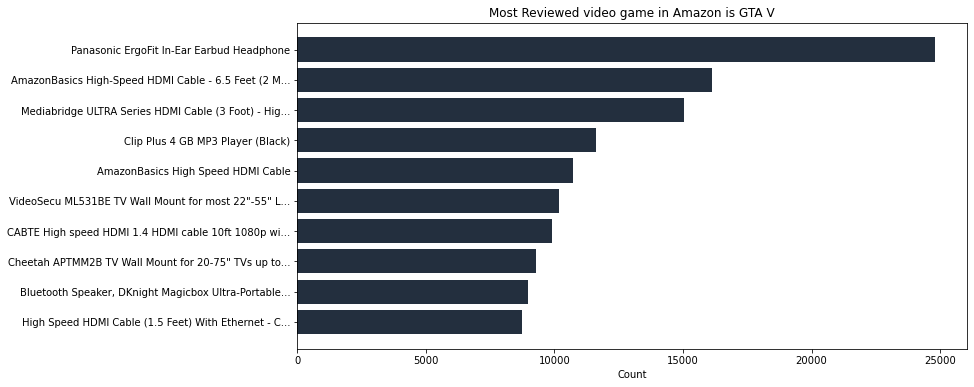

In [10]:
top10_prod = df.product_title.value_counts().head(10)
top10_prod.sort_values(inplace=True)
plt.figure(figsize=(12, 6))

y = [f'{x[:50]}...' if len(x) > 50 else x for x in top10_prod.index]
plt.barh(y, top10_prod)
plt.title('Most Reviewed video game in Amazon is GTA V')
plt.xlabel('Count')
# plt.xlim((1000, 3200))
plt.show()

The most extremely popular videogame in our dataset is GTA V and Nintendo Amiibo. With numerous reviews, it can gain the trust of potential customers based on the reviews in search of reliable opinion. Hence, it can further lead to increase in sales for the particular product.

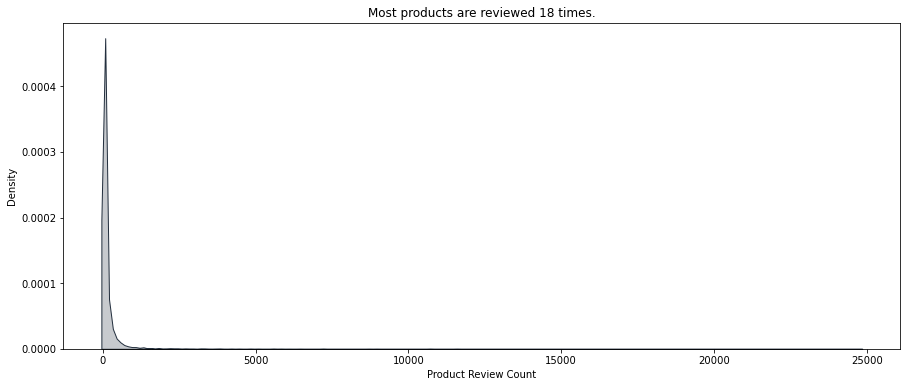

In [11]:
prod_counts = df.product_title.value_counts()
plt.figure(figsize=(15, 6))
sns.kdeplot(prod_counts, shade=True)
plt.title(f'Most products are reviewed {int(prod_counts.mean())} times.')
plt.xlabel('Product Review Count')
plt.show()

The plot above shows that rightly skewed distribution of product review counts. Some products are extremely popular reaching a scale of a thousand reviews, showcasing its reliability (because of many buyers/reviewers). In comparison, most of the products in the dataset are only reviewed around 12 times.

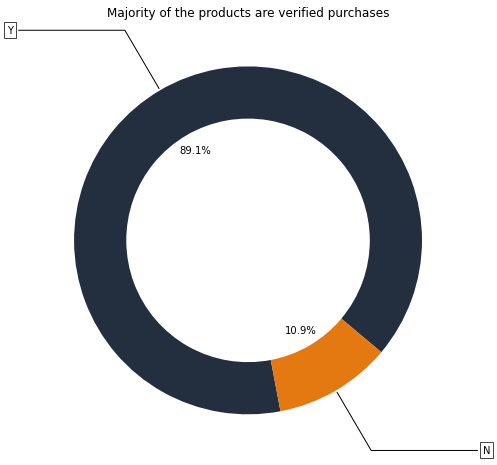

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))
data = df.verified_purchase.value_counts()

wedges, texts, pct = ax.pie(data, wedgeprops=dict(width=0.3),
                            startangle=-40, autopct="%.1f%%")

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(data.index[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title('Majority of the products are verified purchases')

plt.show()

Out of all 330966, only 30370(9.2%) reviews are tagged as verified purchase. In the following sections, we are going to further examine these reviews to determine if they are paid or bot reviews.

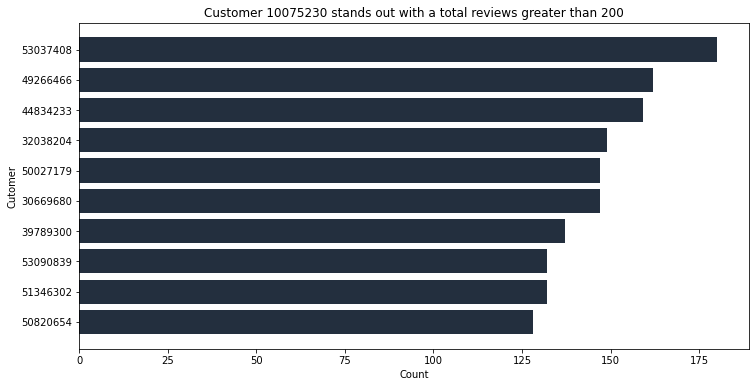

In [13]:
top10_cust = df.customer_id.value_counts().head(10)
top10_cust.sort_values(inplace=True)
plt.figure(figsize=(12, 6))

plt.barh([str(cust) for cust in top10_cust.index], top10_cust)
plt.ylabel('Cutomer')
plt.xlabel('Count')
plt.title('Customer 10075230 stands out with a total reviews greater than 200')
plt.show()

The plot above shows the number of reviews of the top 10 customers with the most reviews. Customer 10075230 stands out as the most active customer in the review section with 218 reviews in total. This customer will definitely will be a person of interest, suspected as a paid or a bot reviewer. Later in this report, we are going to the analyze the relationships of the customers using Network Analysis to see if these customers are connected.

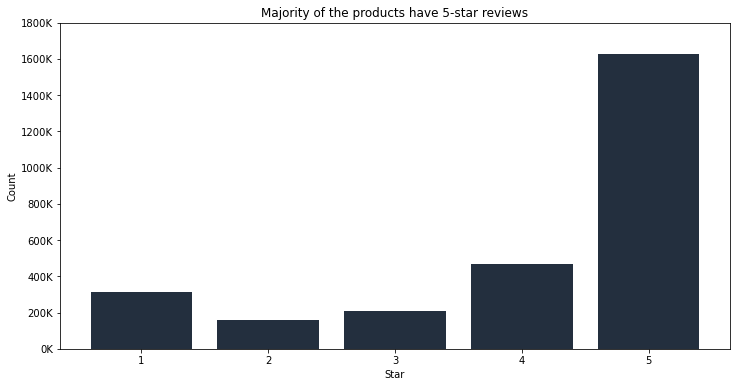

In [14]:
plt.figure(figsize=(12, 6))

plt.bar(df['star_rating'].value_counts().index,
          df['star_rating'].value_counts())
plt.ylabel('Count')
plt.xlabel('Star')
plt.title('Majority of the products have 5-star reviews')
ylabels = [f'{y/1000:.0f}K' for y in plt.gca().get_yticks()]

plt.gca().set_yticks(plt.gca().get_yticks())
plt.gca().set_yticklabels(ylabels)
plt.show()

Most of the reviews in the dataset have 5-star reviews. Either most of the products reviewed are excellent, customers are too lazy to accurately review the products, or these are fake reviews.

# Review Information Network

#### Get the top 500 customers with the highest number of reviews

In [37]:
top_idx = df.customer_id.value_counts().head(1000).index

df_top = df.loc[df.customer_id.isin(top_idx)].copy()

#### Remove Insignificant Words

#### Remove Low Frequency word

#### Get co-occurence of words

#### Create edges for the graph

#### Construct Network Graph

# FIM

customer1: {product1, product2, product3},

customer2: {product1, product2, product4}

## Confidence, Lift, Covariance

# Customer Network

In [131]:
def get_review_metrics(customer_id):
    """Get review metrics."""
    cust_review = df.loc[df.customer_id == customer_id,
                         ['product_title',
                          'review_headline',
                          'review_body']].copy()
    prod_titles = cust_review.product_title.apply(text_cleaner)
    prod_titles = prod_titles.apply(remove_words).tolist()

    review_headlines = cust_review.review_headline.apply(text_cleaner)
    review_headlines = review_headlines.apply(remove_words).tolist()

    review_bodies = cust_review.review_body.apply(text_cleaner)
    review_bodies = review_bodies.apply(remove_words).tolist()

    corpus = list(chain.from_iterable(
        [prod_titles, review_headlines, review_bodies]))
    vectorizer = CountVectorizer().fit(corpus)
    # Transform
    titles = vectorizer.transform(prod_titles).A
    headlines = vectorizer.transform(review_headlines).A
    bodies = vectorizer.transform(review_bodies).A

    return {'customer_id': customer_id,
            'dist_title_body': compare_doc_distance(titles, bodies,
                                                    euclidean),
            'dist_title_headlines': compare_doc_distance(titles, headlines,
                                                         euclidean),
            'dist_headlines_body': compare_doc_distance(headlines, bodies,
                                                        euclidean),
            'dist_each_headlines': get_doc_distance(headlines,
                                                    euclidean),
            'dist_each_body': get_doc_distance(bodies, euclidean)
            }


def compare_doc_distance(bow1, bow2, dist):
    """Compare the distance between the two bag of words"""
    distance = [dist(a1, a2) for a1, a2 in zip(bow1, bow2)]
    return np.mean(distance)


def get_doc_distance(bow, dist):
    """Get the distance of each row in the bag of words"""
    distance = [dist(bow[i], bow[j]) for i in range(bow.shape[0])
                for j in range(bow.shape[0]) if i != j]
    return np.mean(distance)

In [26]:
df_cust = (df_top.groupby(['customer_id'])['product_id']
           .apply(set).to_frame().reset_index())
df_cust['count_prod'] = df_cust.product_id.apply(len)
df_cust.product_id = df_cust.product_id.apply(list)

#### Construct Bi-Partite Graph

In [28]:
bi_partite_G = nx.Graph()
customers = df_cust.customer_id.tolist()
products = df_cust.product_id.tolist()

In [29]:
for idx, cust in enumerate(customers):
    bi_partite_G.add_node(cust, bipartite=0)
    for prod in products[idx]:
        bi_partite_G.add_node(prod, bipartite=1)
        bi_partite_G.add_edge(cust, prod)

In [310]:
# saving graph created above in gexf format
nx.write_gexf(bi_partite_G, "bi_partite_G.gexf")

#### Construct Customer Network

In [30]:
edge_weights = {}
to_remove = []
customer_G = bi_partite_G.copy()
for node in customer_G.nodes(data=True):
    if node[1]['bipartite'] == 1:
        # Remove product nodes
        to_remove.append(node[0])
        neighbours = list(customer_G.neighbors(node[0]))
        for i in range(len(neighbours) - 1):
            for j in range(i+1, len(neighbours)):
                edge = tuple(set((neighbours[i], neighbours[j])))
                if edge in edge_weights:
                    edge_weights[edge]['weight'] += 1
                else:
                    edge_weights[edge] = {'weight' : 1}
                customer_G.add_edge(*edge)

customer_G.remove_nodes_from(to_remove)
nx.set_edge_attributes(customer_G, edge_weights)

In [31]:
isolates = list(nx.isolates(customer_G))
labels = {node: node for node in customer_G.nodes() if node in isolates}

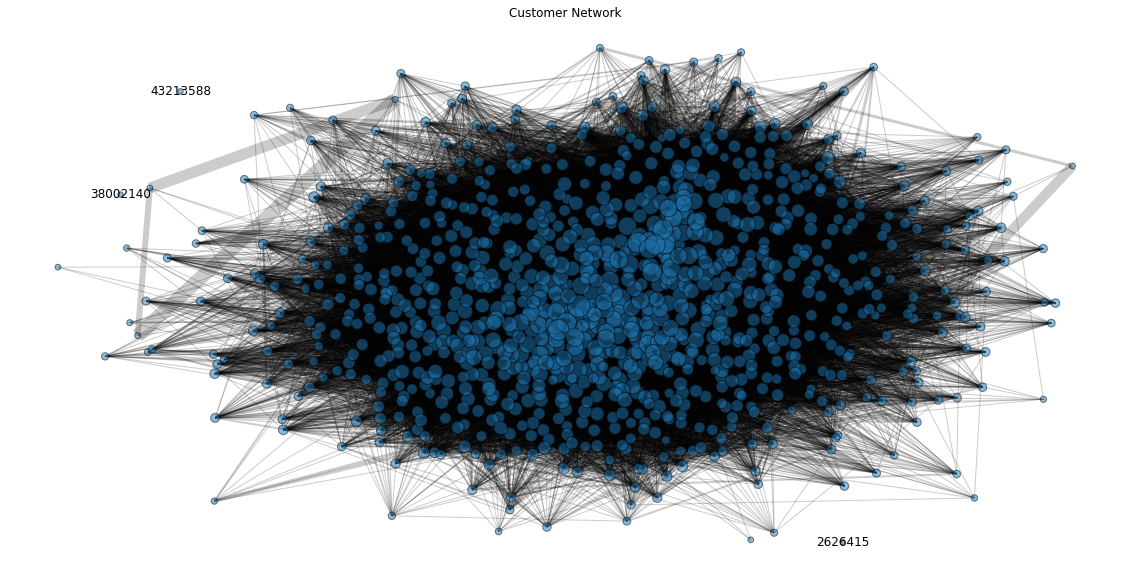

In [32]:
edgelist = [(edge[0], edge[1]) for edge in customer_G.edges(data=True)]
edgewidth = [edge[2]['weight'] for edge in customer_G.edges(data=True)]

fig, ax = plt.subplots(figsize=(20, 10))
ax.axis("off")

node_size = NodeSizeScaler(
    min_size=30, max_size=500).fit_transform(customer_G)

pos = nx.spring_layout(customer_G, k=0.8, seed=11)
nx.draw_networkx_nodes(customer_G, pos, node_size=node_size,
                       alpha=0.5,
                       edgecolors='black',
                       ax=ax)
nx.draw_networkx_edges(customer_G, pos, edgelist=edgelist,
                       width=edgewidth, alpha=0.2, ax=ax)
nx.draw_networkx_labels(customer_G, pos, labels)
plt.title('Customer Network')
plt.show()

In [312]:
# saving graph created above in gexf format
nx.write_gexf(customer_G, "customer_G.gexf")

#### Examine Isolated Components

In [168]:
cust_reviews_stat = []
for customer in tqdm(customers):
    cust_reviews_stat.append(get_review_metrics(customer))
df_cust_reviews_stat = pd.DataFrame(cust_reviews_stat)

In [144]:
cust_reviews_stat_iso = []
for customer in tqdm(isolates):
    cust_reviews_stat_iso.append(get_review_metrics(customer))
df_cust_reviews_stat_iso = pd.DataFrame(cust_reviews_stat_iso)
df_cust_reviews_stat_iso.set_index('customer_id', inplace=True)

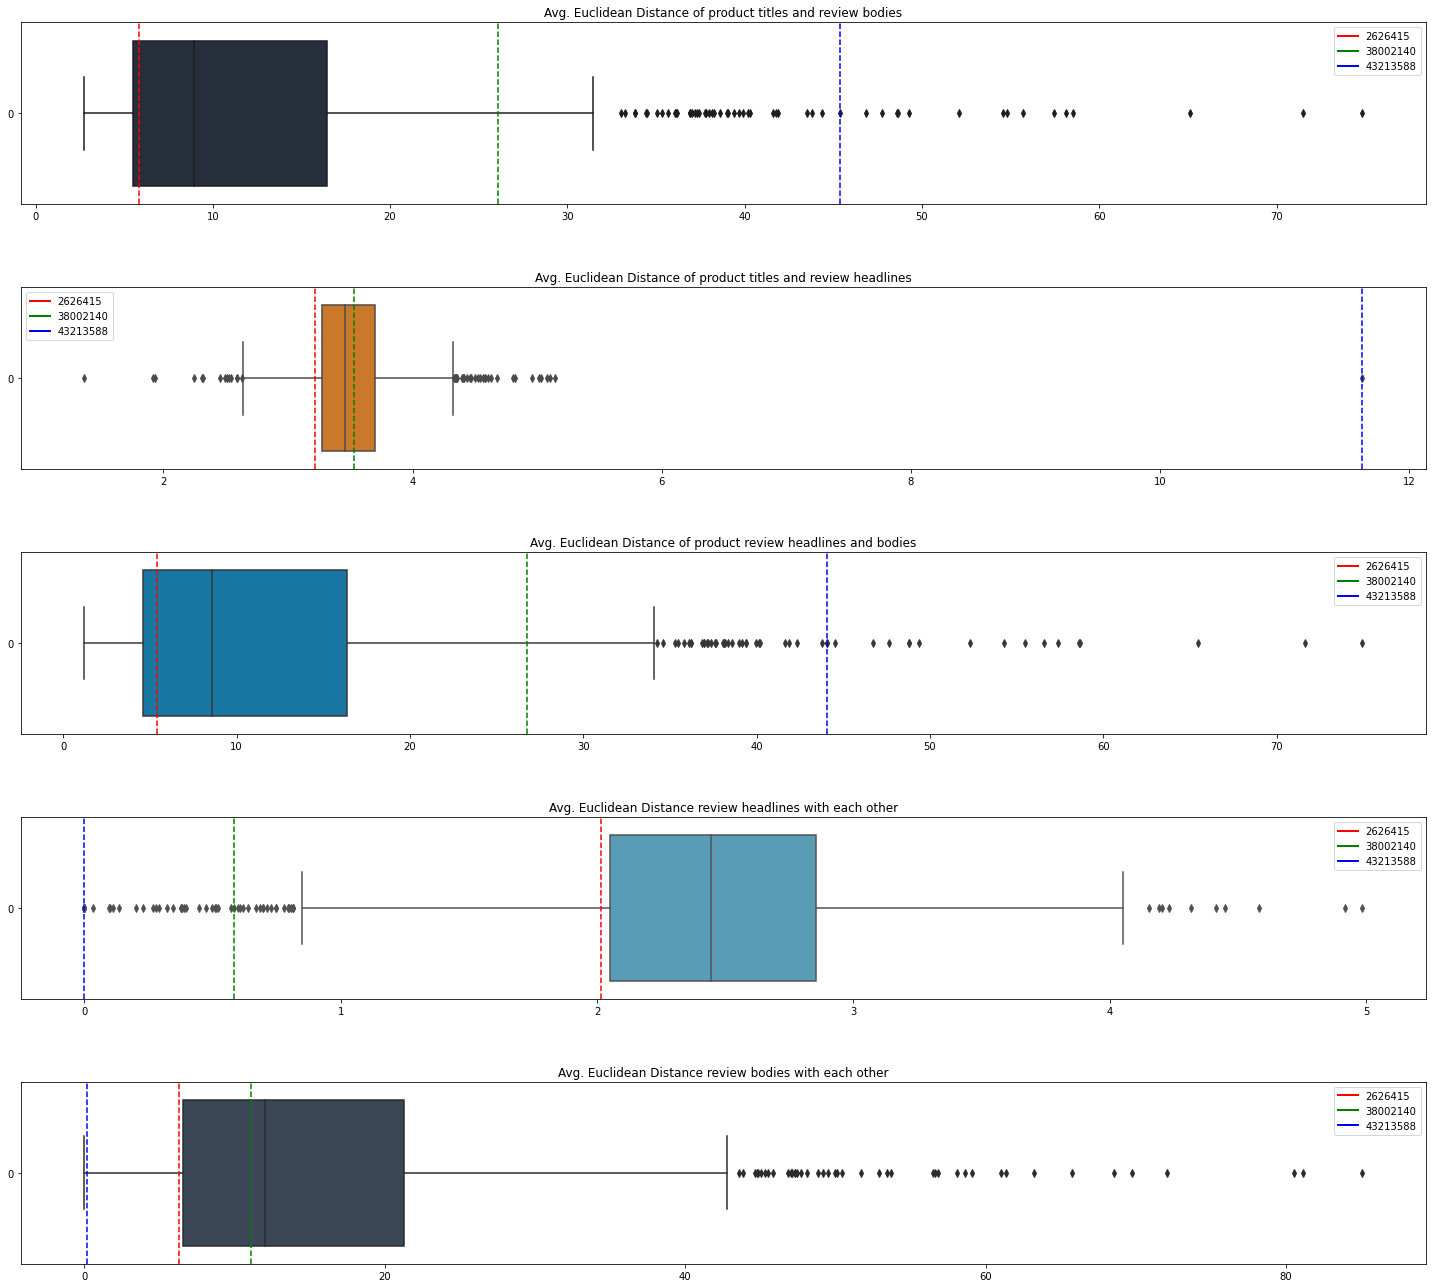

In [199]:
fig, ax = plt.subplots(5, 1, figsize=(20, 18))
titles = ['Avg. Euclidean Distance of product titles and review bodies',
          'Avg. Euclidean Distance of product titles and review headlines',
          'Avg. Euclidean Distance of product review headlines and bodies',
          'Avg. Euclidean Distance review headlines with each other',
          'Avg. Euclidean Distance review bodies with each other']

for idx, title in enumerate(titles):
    sns.boxplot(data=df_cust_reviews_stat.iloc[:, idx+1], orient='h',
                ax=ax[idx], color=aws_palette[idx])
    ax[idx].set_title(title)
    ax[idx].set_ylabel('')
    
    legend_elements = []
    for iso_stat, color in zip((df_cust_reviews_stat_iso.iloc[:, idx]
                                .to_dict().items()),
                               ['red', 'green', 'blue']):
        customer, val = iso_stat[0], iso_stat[1]
        ax[idx].axvline(val, color=color, linestyle='--')
        legend_elements.append(Line2D([0], [0], color=color,
                                      lw=2, label=customer))

    ax[idx].legend(handles=legend_elements)
plt.tight_layout(h_pad=5)
plt.show()

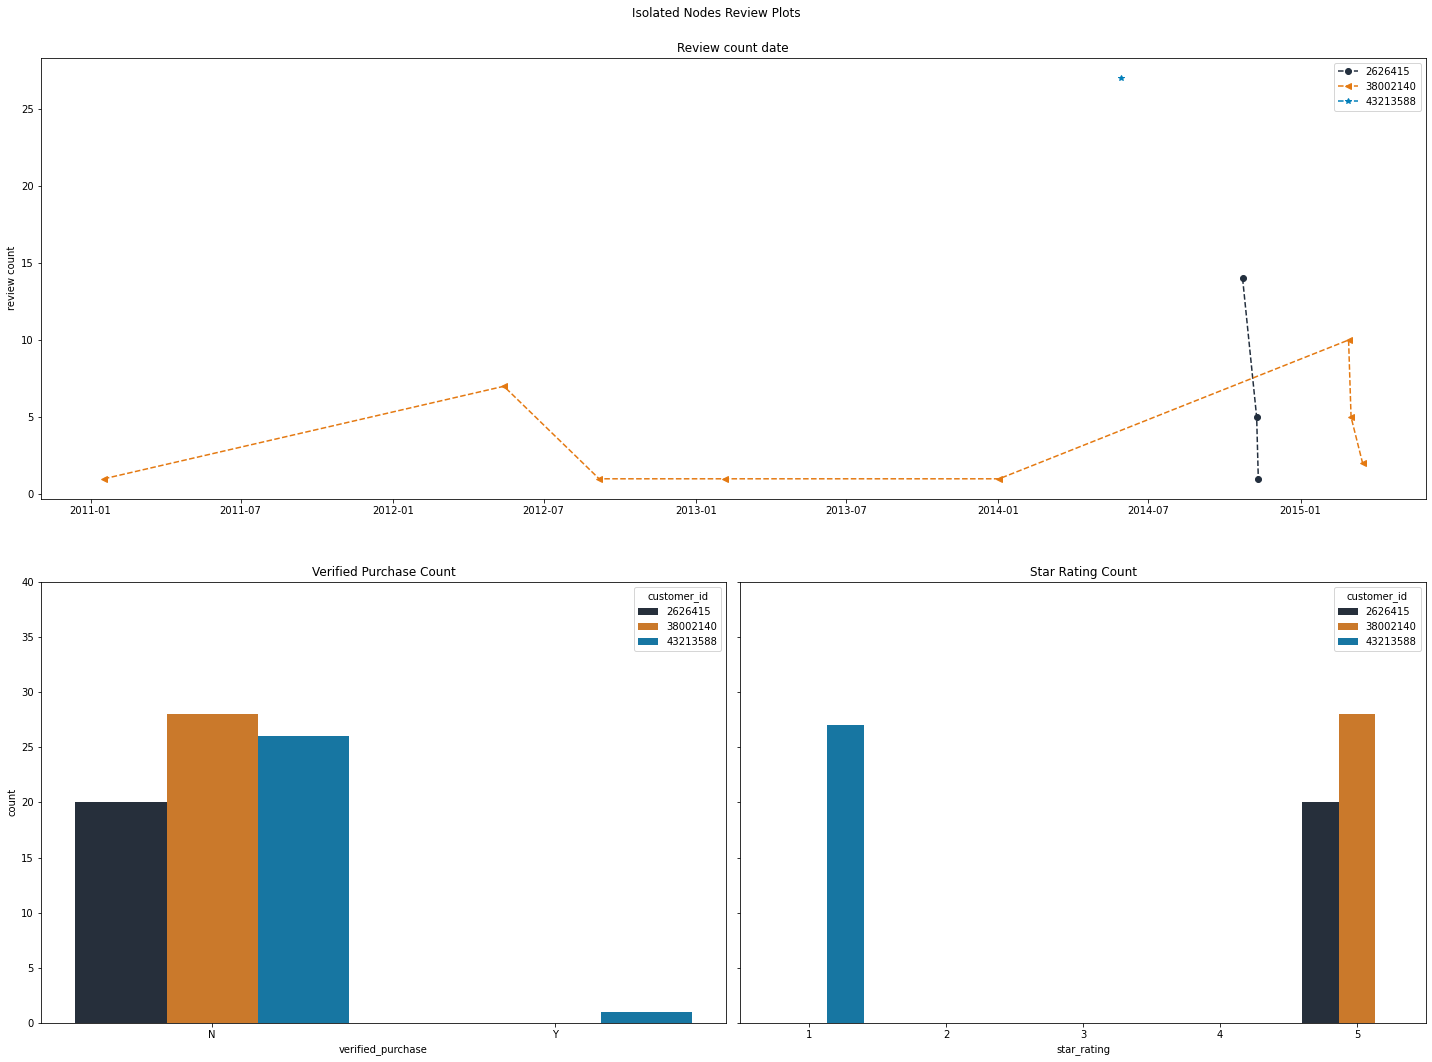

In [229]:
fig = plt.figure(figsize=(20, 15))

gs = GridSpec(2, 2)
ax0 = fig.add_subplot(gs[0, :])

for customer, style in zip(isolates, ['o--', '<--', '*--']):
    df_ts = df.loc[df.customer_id == customer,
                   ['product_id', 'review_date',
                    'verified_purchase', ]]
    df_ts.review_date = pd.to_datetime(df_ts.review_date)
    ts = df_ts.groupby('review_date')['product_id'].apply(len)

    ax0.plot(ts, style)
    ax0.set_ylabel('review count')

ax0.legend(isolates)
ax0.set_title('Review count date')

ax1 = fig.add_subplot(gs[1, 0])
ax1.set_title('Verified Purchase Count')
sns.countplot(x='verified_purchase',
              data=df.loc[df.customer_id.isin(isolates)],
              hue='customer_id',
              ax=ax1
              )
ax1.set_ylim((0, 40))

ax2 = fig.add_subplot(gs[1, 1])
ax2.set_title('Star Rating Count')
sns.countplot(x='star_rating',
              data=df.loc[df.customer_id.isin(isolates)],
              hue='customer_id',
              order=[1, 2, 3, 4, 5],
              ax=ax2)
ax2.set_ylim((0, 40))
ax2.set_ylabel('')
ax2.set_yticklabels([])
plt.suptitle('Isolated Nodes Review Plots')
plt.tight_layout(h_pad=5, rect=[0, 0, 1, 0.98])

In [319]:
isolates

[2626415, 38002140, 43213588]

In [323]:
df.loc[df.customer_id == 2626415,
       ['product_title', 'review_headline',
        'review_body', ]]

,product_title,review_headline,review_body
969445,$20 International Rechargeable Calling Card No...,Awesome product and company,"This card is great. line is crystal clear, ver..."
973940,SHARPER IMAGE Premium NFC Bluetooth HD Speaker,Impressive speakers!,These speakers are incredible. I recently purc...
974092,POLAROID 2014 Portable Bluetooth Speaker,Great Product!,I am very impressed with the purchase of this ...
974917,POLAROID Sport Headphones with Mic,Great headphones!,After purchasing these headphones they have be...
975271,POLAROID 2014 Portable Bluetooth Speaker for A...,Love this speaker!,speakers are incredible. I recently purchased ...
975563,POLAROID Bluetooth Tall Tower Speaker System w...,Worth every penny!,These speakers are incredible. I recently purc...
1014013,Polaroid Built-In Sports Clip Touch Screen Mp3...,amazing mp3 player!,This built in sports clip touch screen Mp3 is ...
1014116,SHARPER IMAGE SHP921 Universal Wireless Headph...,AMAZING PRODUCT!,I recently purchased these headphones off amaz...
1014222,SHARPER IMAGE Universal Wireless Bluetooth Spe...,5 star all the way!,I recently purchased this product and it is fa...
1014784,SHARPER IMAGE SHP891BL Premium Tangle Free Ear...,Great product!,I recently purchased these headphones off amaz...


#### Analyze Giant Component

In [231]:
customer_giant_G = customer_G.subgraph(
    max(nx.connected_components(customer_G), key=len))

Network Properties:
N = 997
L = 63211
avg_degree = 63.401203610832496
max_degree = 449
min_degree = 3
density = 0.06365582691850652
avg_shortest_path = 1.8961059886486769
avg_clustering_coeff = 0.33411368410965364
shortest_path_length_max = 4.0
shortest_path_length_max_edge = (14308733, 22485550)
is_connected = True
maximal_cliques = 105


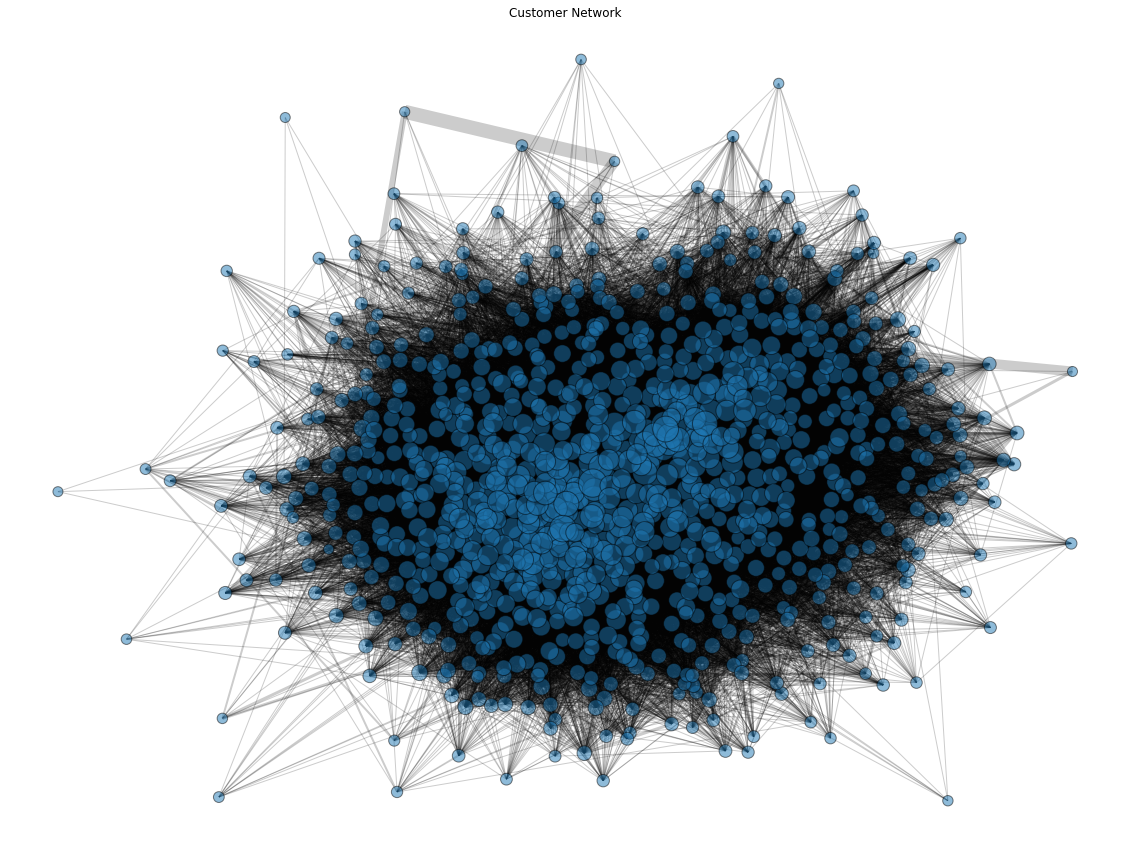

In [232]:
edgelist = [(edge[0], edge[1]) for edge in customer_giant_G.edges(data=True)]
edgewidth = [edge[2]['weight'] for edge in customer_giant_G.edges(data=True)]

fig, ax = plt.subplots(figsize=(20, 15))
ax.axis("off")

node_size = NodeSizeScaler(
    min_size=100, max_size=800).fit_transform(customer_giant_G)

pos = nx.fruchterman_reingold_layout(customer_giant_G, k=0.7, seed=11)
nx.draw_networkx_nodes(customer_giant_G, pos, node_size=node_size,
                       alpha=0.5,
                       edgecolors='black',
                       ax=ax)
nx.draw_networkx_edges(customer_giant_G, pos, edgelist=edgelist,
                       width=edgewidth, alpha=0.2, ax=ax)

print(nxa.NetworkProperties(customer_giant_G))
plt.title('Customer Network')
plt.show()

In [278]:
# saving graph created above in gexf format
nx.write_gexf(customer_giant_G, "customer_giant_G.gexf")

##### Nodes with Lowest Degree

In [279]:
least_deg_node = sorted(customer_giant_G.degree(), key=lambda x: x[1])[:5]
print(('Customer {} has the least number of connections in '
       'the giant component with a {} connections').format(*least_deg_node[0]))

Customer 12720950 has the least number of connections in the giant component with a 3 connections


In [280]:
least_deg_nodes = [x[0] for x in least_deg_node]
least_deg_nodes

[12720950, 23420928, 14308733, 44299540, 38382633]

In [281]:
cust_reviews_stat_lst = []
for customer in tqdm(least_deg_nodes):
    cust_reviews_stat_lst.append(get_review_metrics(customer))
df_cust_reviews_stat_lst = pd.DataFrame(cust_reviews_stat_lst)
df_cust_reviews_stat_lst.set_index('customer_id', inplace=True)

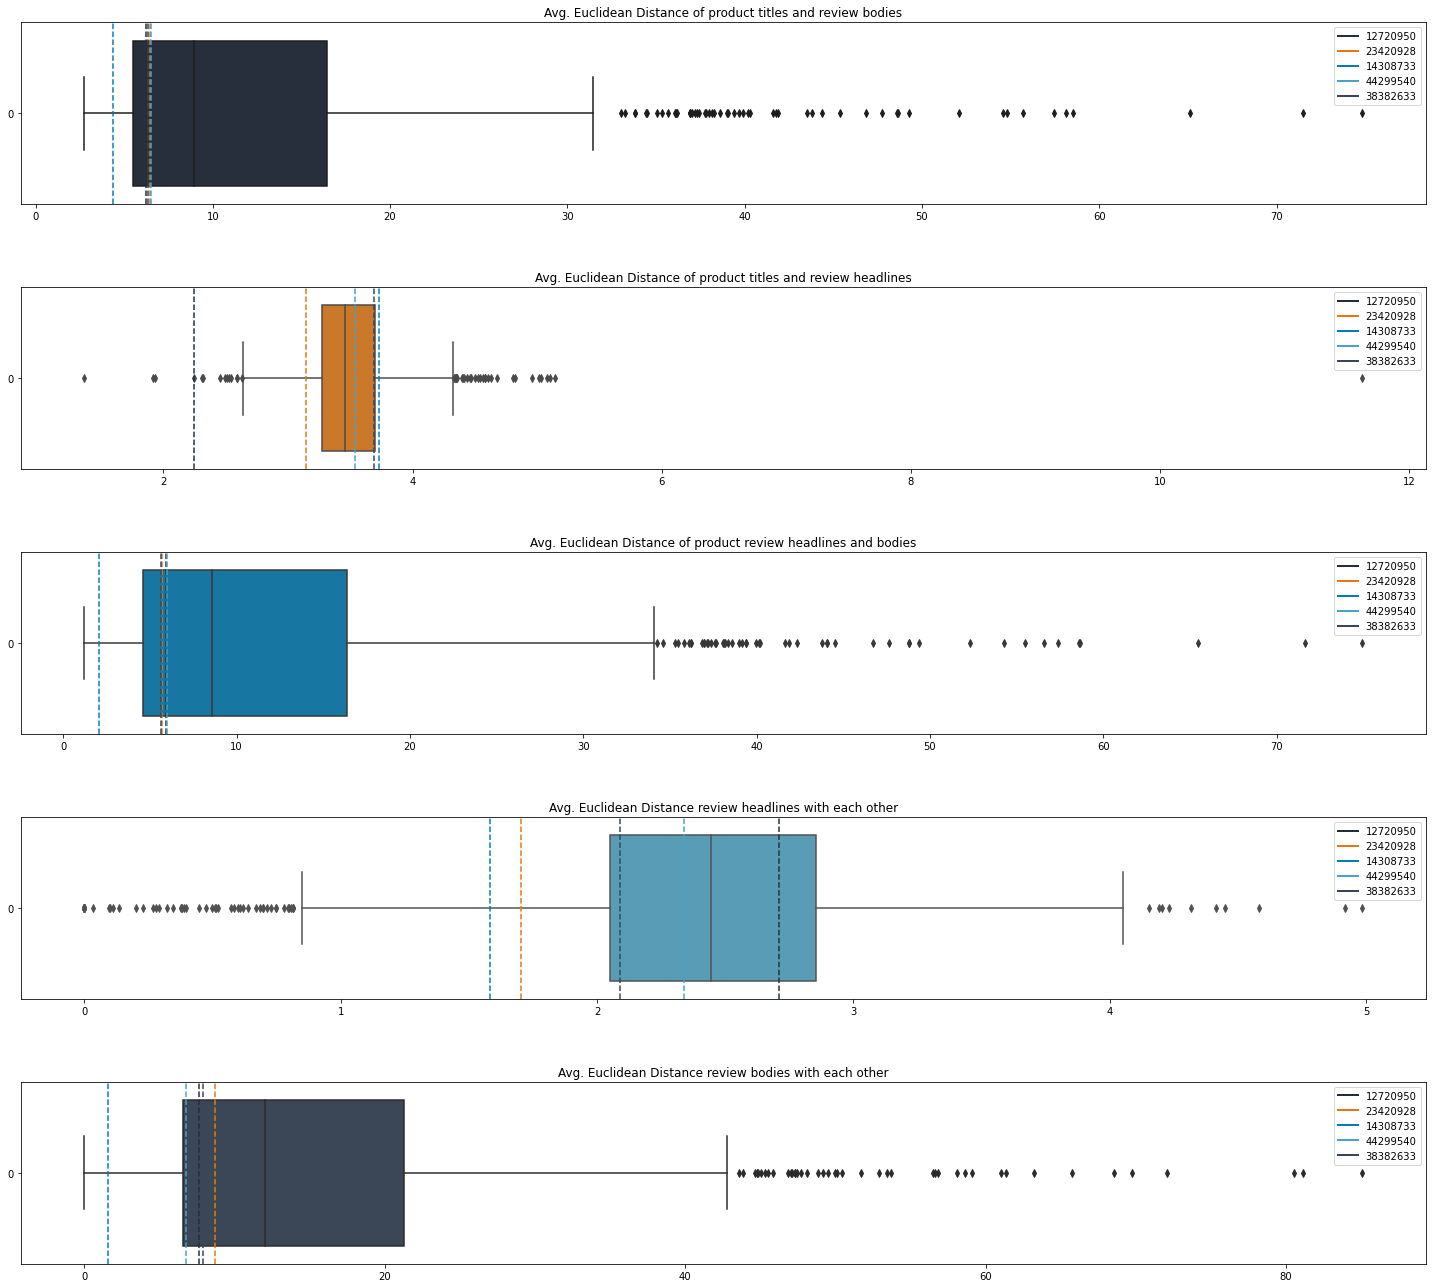

In [283]:
fig, ax = plt.subplots(5, 1, figsize=(20, 18))
titles = ['Avg. Euclidean Distance of product titles and review bodies',
          'Avg. Euclidean Distance of product titles and review headlines',
          'Avg. Euclidean Distance of product review headlines and bodies',
          'Avg. Euclidean Distance review headlines with each other',
          'Avg. Euclidean Distance review bodies with each other']

for idx, title in enumerate(titles):
    sns.boxplot(data=df_cust_reviews_stat.iloc[:, idx+1], orient='h',
                ax=ax[idx], color=aws_palette[idx])
    ax[idx].set_title(title)
    ax[idx].set_ylabel('')
    
    legend_elements = []
    for lst_stat, color in zip((df_cust_reviews_stat_lst.iloc[:, idx]
                                .to_dict().items()),
                               aws_palette):
        customer, val = lst_stat[0], lst_stat[1]
        ax[idx].axvline(val, color=color, linestyle='--')
        legend_elements.append(Line2D([0], [0], color=color,
                                      lw=2, label=customer))

    ax[idx].legend(handles=legend_elements)
plt.tight_layout(h_pad=5)
plt.show()

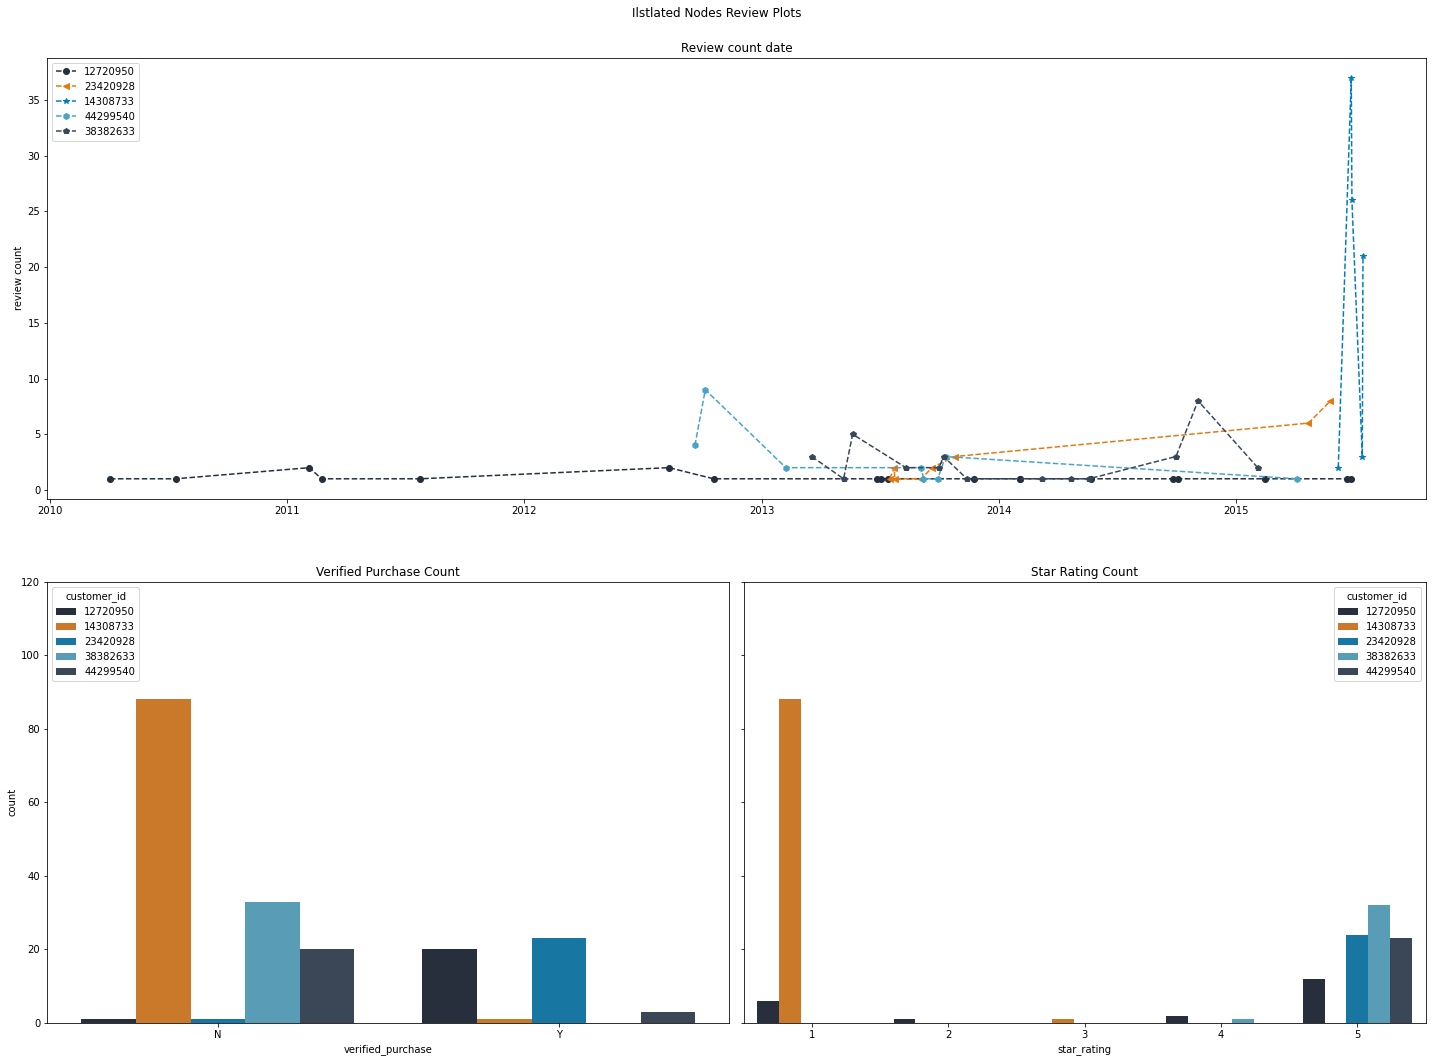

In [290]:
fig = plt.figure(figsize=(20, 15))

gs = GridSpec(2, 2)
ax0 = fig.add_subplot(gs[0, :])

for customer, style in zip(least_deg_nodes, ['o--', '<--', '*--',
                                             'h--', 'p--']):
    df_ts = df.loc[df.customer_id == customer,
                   ['product_id', 'review_date',
                    'verified_purchase', ]]
    df_ts.review_date = pd.to_datetime(df_ts.review_date)
    ts = df_ts.groupby('review_date')['product_id'].apply(len)

    ax0.plot(ts, style)
    ax0.set_ylabel('review count')

ax0.legend(least_deg_nodes)
ax0.set_title('Review count date')

ax1 = fig.add_subplot(gs[1, 0])
ax1.set_title('Verified Purchase Count')
sns.countplot(x='verified_purchase',
              data=df.loc[df.customer_id.isin(least_deg_nodes)],
              hue='customer_id',
              order=['N', 'Y'],
              ax=ax1
              )
ax1.set_ylim((0, 120))

ax2 = fig.add_subplot(gs[1, 1])
ax2.set_title('Star Rating Count')
sns.countplot(x='star_rating',
              data=df.loc[df.customer_id.isin(least_deg_nodes)],
              hue='customer_id',
              order=[1, 2, 3, 4, 5],
              ax=ax2)
ax2.set_ylim((0, 120))
ax2.set_ylabel('')
ax2.set_yticklabels([])
plt.suptitle('Ilstlated Nodes Review Plots')
plt.tight_layout(h_pad=5, rect=[0, 0, 1, 0.98])

##### Nodes with Highest Degree

In [291]:
most_deg_node = sorted(customer_giant_G.degree(), key=lambda x: -x[1])[:5]
print(('Customer {} has the highest number of connections in the '
       'giant component with a {} connections').format(*most_deg_node[0]))

Customer 48228332 has the highest number of connections in the giant component with a 449 connections


In [292]:
most_deg_nodes = [x[0] for x in most_deg_node]
most_deg_nodes

[48228332, 49754552, 45070473, 49266466, 52938899]

In [293]:
cust_reviews_stat_mst = []
for customer in tqdm(most_deg_nodes):
    cust_reviews_stat_mst.append(get_review_metrics(customer))
df_cust_reviews_stat_mst = pd.DataFrame(cust_reviews_stat_mst)
df_cust_reviews_stat_mst.set_index('customer_id', inplace=True)

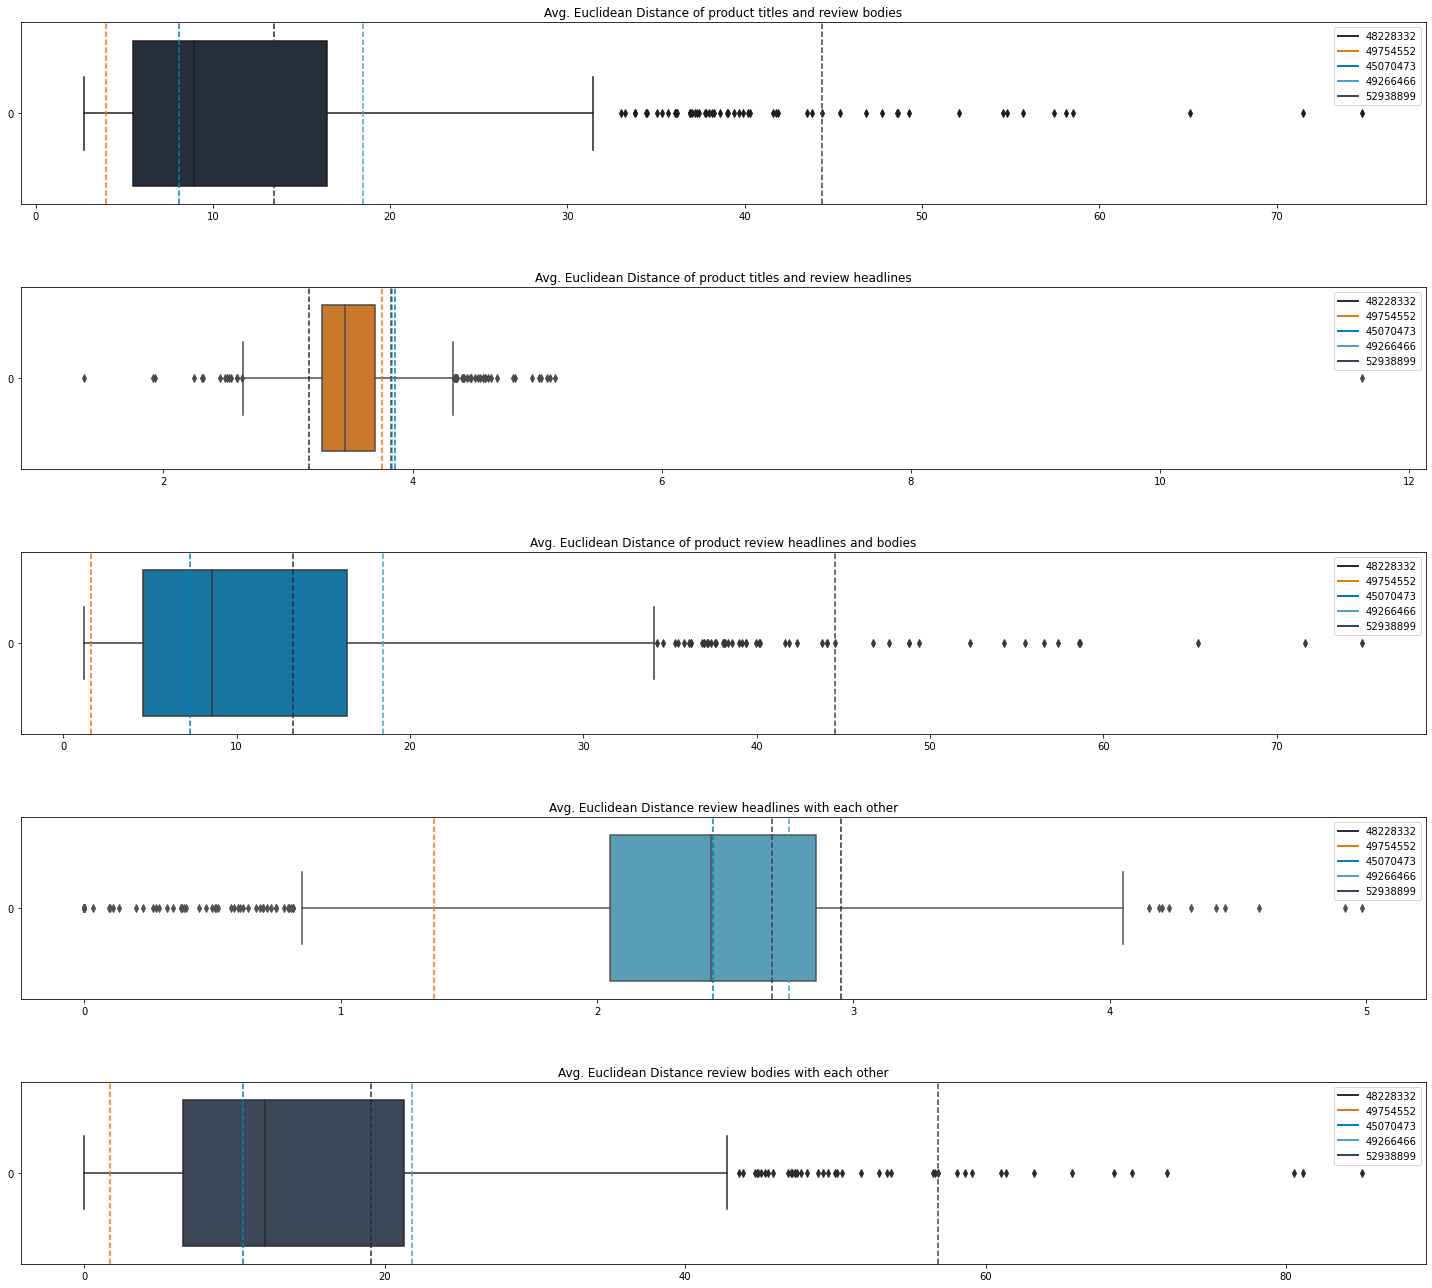

In [294]:
fig, ax = plt.subplots(5, 1, figsize=(20, 18))
titles = ['Avg. Euclidean Distance of product titles and review bodies',
          'Avg. Euclidean Distance of product titles and review headlines',
          'Avg. Euclidean Distance of product review headlines and bodies',
          'Avg. Euclidean Distance review headlines with each other',
          'Avg. Euclidean Distance review bodies with each other']

for idx, title in enumerate(titles):
    sns.boxplot(data=df_cust_reviews_stat.iloc[:, idx+1], orient='h',
                ax=ax[idx], color=aws_palette[idx])
    ax[idx].set_title(title)
    ax[idx].set_ylabel('')

    legend_elements = []
    for lst_stat, color in zip((df_cust_reviews_stat_mst.iloc[:, idx]
                                .to_dict().items()),
                               aws_palette):
        customer, val = lst_stat[0], lst_stat[1]
        ax[idx].axvline(val, color=color, linestyle='--')
        legend_elements.append(Line2D([0], [0], color=color,
                                      lw=2, label=customer))

    ax[idx].legend(handles=legend_elements)
plt.tight_layout(h_pad=5)
plt.show()

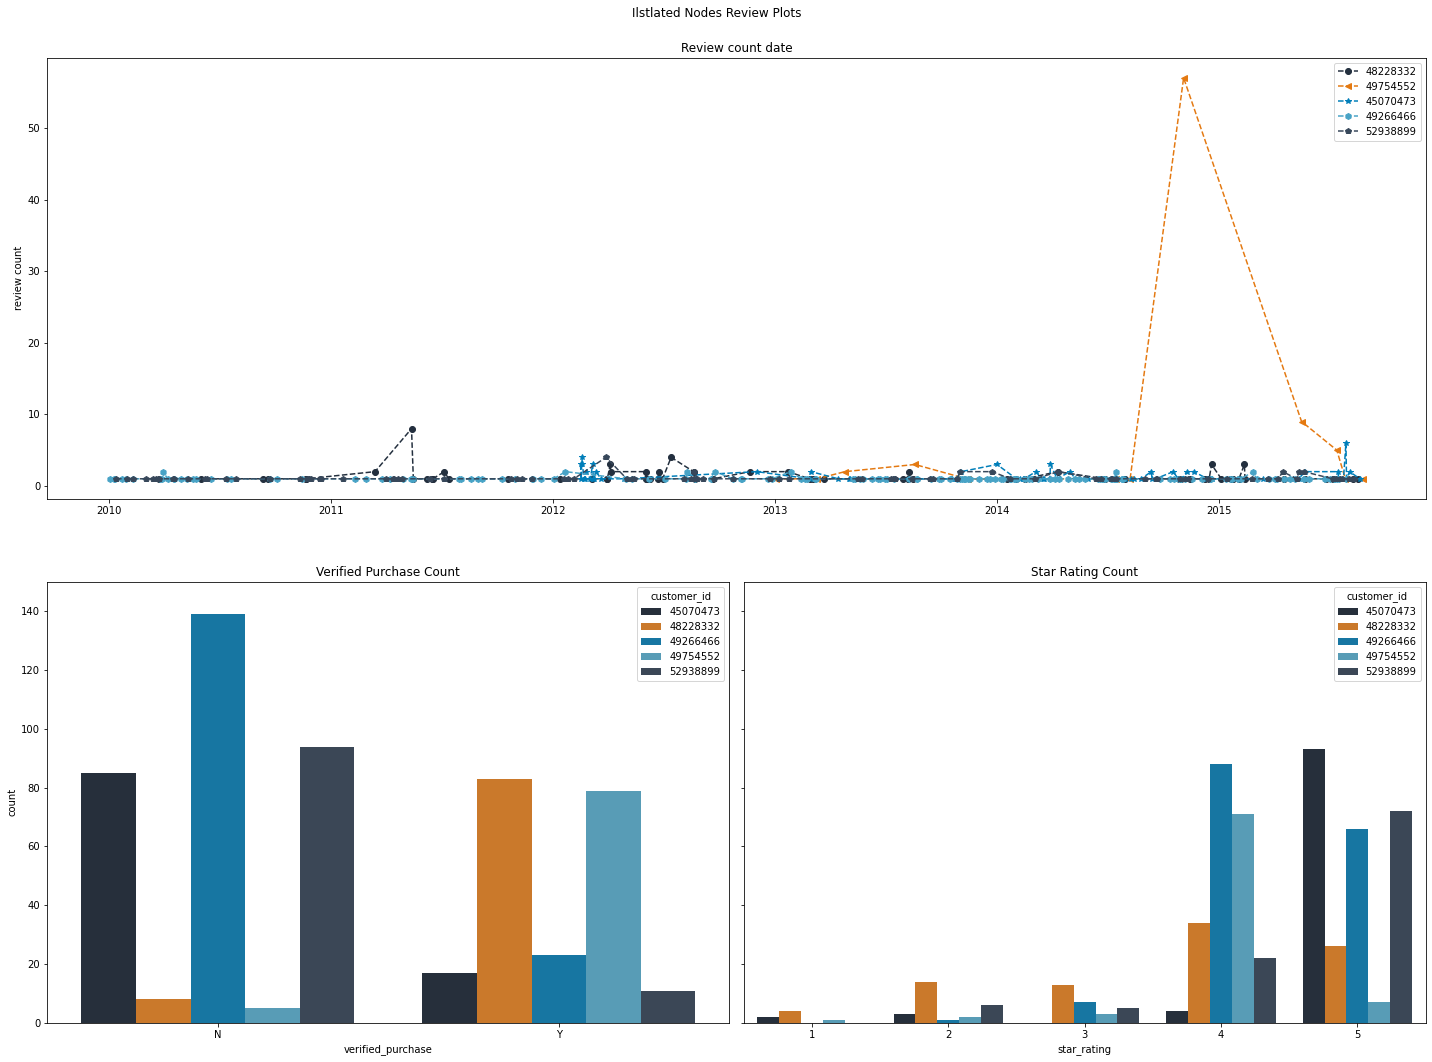

In [299]:
fig = plt.figure(figsize=(20, 15))

gs = GridSpec(2, 2)
ax0 = fig.add_subplot(gs[0, :])

for customer, style in zip(most_deg_nodes, ['o--', '<--', '*--',
                                            'h--', 'p--']):
    df_ts = df.loc[df.customer_id == customer,
                   ['product_id', 'review_date',
                    'verified_purchase', ]]
    df_ts.review_date = pd.to_datetime(df_ts.review_date)
    ts = df_ts.groupby('review_date')['product_id'].apply(len)

    ax0.plot(ts, style)
    ax0.set_ylabel('review count')

ax0.legend(most_deg_nodes)
ax0.set_title('Review count date')

ax1 = fig.add_subplot(gs[1, 0])
ax1.set_title('Verified Purchase Count')
sns.countplot(x='verified_purchase',
              data=df.loc[df.customer_id.isin(most_deg_nodes)],
              hue='customer_id',
              order=['N', 'Y'],
              ax=ax1
              )
ax1.set_ylim((0, 150))

ax2 = fig.add_subplot(gs[1, 1])
ax2.set_title('Star Rating Count')
sns.countplot(x='star_rating',
              data=df.loc[df.customer_id.isin(most_deg_nodes)],
              hue='customer_id',
              order=[1, 2, 3, 4, 5],
              ax=ax2)
ax2.set_ylabel('')
ax2.set_yticklabels([])
ax2.set_ylim((0, 150))
plt.suptitle('Ilstlated Nodes Review Plots')
plt.tight_layout(h_pad=5, rect=[0, 0, 1, 0.98])

In [296]:
most_deg_nodes

[48228332, 49754552, 45070473, 49266466, 52938899]

In [307]:
df.loc[(df.customer_id.isin(most_deg_nodes)) & (df.vine=='Y')].customer_id.unique()

array([49266466, 52938899], dtype=int64)

In [309]:
df.loc[df.customer_id==45070473, ['product_title','review_headline', 'review_body', 'vine']].copy()

,product_title,review_headline,review_body,vine
33566,Black Box F1S Dashboard Dash Cam Full HD 1080P...,Fish eyed camera/camcorder!,"This is a Full-HD Video 1080P at 30 fps, supe...",N
92538,"USB Wall Charger,Mopower 7.2A 36W Portable 4-P...",I love things that can effectively reduce clutter,I love things that can effectively reduce clut...,N
93636,Mopower 3Ft Male to Male 3.5mm Premium Auxilia...,The cable is perfect for my Toyota Siena AUX c...,The cable is perfect for my Toyota Siena AUX c...,N
106393,[Newest Outdoor&Waterproof Bluetooth Speaker] ...,Excellent value - speaker and powerbank in one!,[[VIDEOID:c5c062499bf9bc1b615aae5b1c3ffcfd]]Ha...,N
109646,"LIHAO 10x 13"" Black Hoop and Loop Fastening Ca...",Great for organizing and decluttering,Great for organizing and decluttering.. I got ...,N
...,...,...,...,...
2430158,Onkyo TX - NR609 7.2 Channel Network THX Certi...,Excellent Receiver,I used it with an Onkyo's set of speakers and ...,N
2430512,Ckitze 3-Round Universal USA to India Africa G...,Worked great in India..,I took 4 of these to India and they worked eve...,N
2431200,Yamaha YHT-895BL Complete 7.1-Channel Home The...,Awesome set,"I started reviewing home theater in a box set,...",N
2431428,RCA Speaker Wire,"Very nice cable, great quality",I purchased it for use with Yamaha YHT 895 HTI...,N


In [80]:
titles, headlines, bodies = analyze_reviews(1035442)
print('Difference between product titles and review bodies', compare_doc_distance(titles.A, bodies.A, euclidean))
print('Difference between product titles and review headlines', compare_doc_distance(titles.A, headlines.A, euclidean))
print('Difference between product review headlines and bodies', compare_doc_distance(headlines.A, bodies.A, euclidean))
print('Difference between each review', get_doc_distance(bodies.A, euclidean))

Difference between product titles and review bodies 13.90136749912658
Difference between product titles and review headlines 5.015193100187083
Difference between product review headlines and bodies 13.675365392652523
Difference between each review 18.60255949713036


In [81]:
df.loc[df.customer_id==1035442, ['product_title','review_headline', 'review_body']].copy()

,product_title,review_headline,review_body
26899,Tomameri Black Portable MP4 Player MP3 Player ...,Black Portable MP4 Player with (32GB) Micro SD...,Ready to go right out of the package - headpho...
69776,Masione Power Socket With 5 Outlet 2 X USB Cha...,POWER Outlet Stick (5) outlets (2) USB ports -...,Helpful in so many ways - with all these elect...
179142,G.G.Martinsen 32 GB Mini Usb Port Slim Small M...,"32 GB internal memory, USB port Transfer - MP3...",This mp3 player has an internal 32 GB memory c...
187312,AGPtek Original STYLE Outdoor Handsfree Blueto...,Portable Bluetooth Speaker with Light show - G...,Right out of the box this speaker was ready to...
197271,abcGOODefg® Wireless Bluetooth 3.0 Music Fount...,Light show dancing water speakers - connects t...,Entertaining to watch the light show provided ...
219177,SOAIY S-52 Wireless NFC/Bluetooth 4.0 Speaker ...,LED wireless bluetooth speaker - Dancing color...,[[VIDEOID:d669f9812d7326789e5cf5a0ca73a796]]Be...
247401,G.G.Martinsen Portable Mp3/mp4 Player 16 GB Blue,"16GB MP3 player - Perfect for a young adult, a...",Great gift idea for a boy - This blue mp3 play...
248452,G.G.Martinsen 16 GB Mini Usb Port Slim Small M...,PINK 16GB Memory (internal) - USB transfer for...,Nothing at all wrong with using a more afforda...
249003,G.G.Martinsen 16 GB Mini Usb Port Slim Small M...,"16GB Silver MP3 player - Nice price, very affo...",16GB internal memory holds plenty of media for...
249906,G.G.Martinsen 16GB Mini USB Port Mp3/Mp4 Playe...,"Black, sleek looking - Portable 16GB USB port ...",The black color of this mp3 player looks reall...


In [85]:
titles, headlines, bodies = analyze_reviews(2626415)
print('Difference between product titles and review bodies', compare_doc_distance(titles.A, bodies.A, euclidean))
print('Difference between product titles and review headlines', compare_doc_distance(titles.A, headlines.A, euclidean))
print('Difference between product review headlines and bodies', compare_doc_distance(headlines.A, bodies.A, euclidean))
print('Difference between each review headlines', get_doc_distance(headlines.A, euclidean))
print('Difference between each review body', get_doc_distance(bodies.A, euclidean))

Difference between product titles and review bodies 5.808496289973802
Difference between product titles and review headlines 3.220669395929261
Difference between product review headlines and bodies 5.416577768621647
Difference between each review headlines 2.0146567016181476
Difference between each review body 6.3128000796140205


In [86]:
df.loc[df.customer_id==2626415, ['product_title','review_headline', 'review_body']].copy()

,product_title,review_headline,review_body
969445,$20 International Rechargeable Calling Card No...,Awesome product and company,"This card is great. line is crystal clear, ver..."
973940,SHARPER IMAGE Premium NFC Bluetooth HD Speaker,Impressive speakers!,These speakers are incredible. I recently purc...
974092,POLAROID 2014 Portable Bluetooth Speaker,Great Product!,I am very impressed with the purchase of this ...
974917,POLAROID Sport Headphones with Mic,Great headphones!,After purchasing these headphones they have be...
975271,POLAROID 2014 Portable Bluetooth Speaker for A...,Love this speaker!,speakers are incredible. I recently purchased ...
975563,POLAROID Bluetooth Tall Tower Speaker System w...,Worth every penny!,These speakers are incredible. I recently purc...
1014013,Polaroid Built-In Sports Clip Touch Screen Mp3...,amazing mp3 player!,This built in sports clip touch screen Mp3 is ...
1014116,SHARPER IMAGE SHP921 Universal Wireless Headph...,AMAZING PRODUCT!,I recently purchased these headphones off amaz...
1014222,SHARPER IMAGE Universal Wireless Bluetooth Spe...,5 star all the way!,I recently purchased this product and it is fa...
1014784,SHARPER IMAGE SHP891BL Premium Tangle Free Ear...,Great product!,I recently purchased these headphones off amaz...


In [84]:
titles, headlines, bodies = analyze_reviews(43213588)
print('Difference between product titles and review bodies', compare_doc_distance(titles.A, bodies.A, euclidean))
print('Difference between product titles and review headlines', compare_doc_distance(titles.A, headlines.A, euclidean))
print('Difference between product review headlines and  bodies', compare_doc_distance(headlines.A, bodies.A, euclidean))
print('Difference between each review headlines', get_doc_distance(headlines.A, euclidean))
print('Difference between each review body', get_doc_distance(bodies.A, euclidean))

Difference between product titles and review bodies 45.3500126183781
Difference between product titles and review headlines 11.618950038622248
Difference between product review headlines and  bodies 44.08739090626747
Difference between each review headlines 0.0
Difference between each review body 0.16563466499998444


In [68]:
df.loc[df.customer_id==43213588, ['product_title','review_headline', 'review_body']].copy()

,product_title,review_headline,review_body
1361809,90 pcs CR123A Bulk 3v Lithium Battery Compatib...,Buyer Beware: These CR123 batteries have EXPIRED!,"Advertised here by the seller as, &#34;100% ne..."
1361889,400 pcs CR123A Bulk 3v Lithium Battery Compati...,Buyer Beware: These CR123 batteries have EXPIRED!,"Advertised here by the seller as, &#34;100% ne..."
1361923,20 pcs CR123A Bulk 3v Lithium Battery Compatib...,Buyer Beware: These CR123 batteries have EXPIRED!,"Advertised here by the seller as, &#34;100% ne..."
1361924,150 pcs CR123A Bulk 3v Lithium Battery Compati...,Buyer Beware: These CR123 batteries have EXPIRED!,"Advertised here by the seller as, &#34;100% ne..."
1362001,350 pcs CR123A Bulk 3v Lithium Battery Compati...,Buyer Beware: These CR123 batteries have EXPIRED!,"Advertised here by the seller as, &#34;100% ne..."
1362023,800 pcs CR123A Bulk 3v Lithium Battery Compati...,Buyer Beware: These CR123 batteries have EXPIRED!,"Advertised here by the seller as, &#34;100% ne..."
1362137,25 pcs CR123A Bulk 3v Lithium Battery Compatib...,Buyer Beware: These CR123 batteries have EXPIRED!,"Advertised here by the seller as, &#34;100% ne..."
1362190,4 pcs CR123A Bulk 3v Lithium Battery Compatibl...,Buyer Beware: These CR123 batteries have EXPIRED!,"Advertised here by the seller as, &#34;100% ne..."
1362210,900 pcs CR123A Bulk 3v Lithium Battery Compati...,Buyer Beware: These CR123 batteries have EXPIRED!,"Advertised here by the seller as, &#34;100% ne..."
1362304,600 pcs CR123A Bulk 3v Lithium Battery Compati...,Buyer Beware: These CR123 batteries have EXPIRED!,"Advertised here by the seller as, &#34;100% ne..."


In [83]:
titles, headlines, bodies = analyze_reviews(38002140)
print('Difference between product titles and review bodies', compare_doc_distance(titles.A, bodies.A, euclidean))
print('Difference between product titles and review headlines', compare_doc_distance(titles.A, headlines.A, euclidean))
print('Difference between product review headlines and  bodies', compare_doc_distance(headlines.A, bodies.A, euclidean))
print('Difference between each review headlines', get_doc_distance(headlines.A, euclidean))
print('Difference between each review body', get_doc_distance(bodies.A, euclidean))

Difference between product titles and review bodies 26.110431496386354
Difference between product titles and review headlines 3.531347737383547
Difference between product review headlines and  bodies 26.776637812313016
Difference between each review headlines 0.5823909597264941
Difference between each review body 11.057731015286384


In [82]:
df.loc[df.customer_id==38002140, ['product_title','review_headline', 'review_body']].copy()

,product_title,review_headline,review_body
522232,Fujifilm Zip 250 IBM (2-Pack) (Discontinued by...,Flexible Data Storage,ZIP 250 MB Disk<br /><br />The 250 MB disk is ...
523030,Fujifilm 250MB IBM Zip Disk PC Formatted (1-Pa...,Flexible Data Storage,ZIP 250 MB Disk<br /><br />The 250 MB disk is ...
572149,Iomega 250MB Zip Disk Six Pack for PC (Discont...,Flexible Data Storage,ZIP 250MB Disk<br /><br />The 250 MB disk is a...
572368,Iomega 6PK ZIP 250MB 6PK SLEEVE PC/MAC ( 32631 ),Flexible Data Storage,ZIP 250MB Disk<br /><br />The 250 MB disk is a...
573141,Iomega Single 250MB IBM Zip Disk (31806),Flexible Data Storage,ZIP 250 MB Disk<br /><br />The 250 MB disk is ...
573866,"Iomega Zip 250MB Cartridge (PC Formatted, 2-Pa...",Flexible Data Storage,ZIP 250 MB Disk<br /><br />The 250 MB disk is ...
574186,Iomega 4PK ZIP 250MB DISKS IN SLEEVES - PC/MAC...,Flexible Data Storage,ZIP 250MB Disk<br /><br />The 250 MB disk is a...
584366,"Iomega Zip 100MB Cartridge (PC Formatted, 3-Pa...",Flexible Data Storage,IOMEGA ZIP 100 Disk<br /><br />The IOMEGA ZIP ...
584775,"Fujifilm 100 MB Zip Disks (5-Pack, Assorted Co...",Flexible Data Storage,ZIP 100MB Disk<br /><br />These ZIP 100MB disk...
584924,"Fujifilm 100 MB Zip Disk, IBM Formatted (10-Pack)",Flexible Data Storage,ZIP 100MB Disk These ZIP 100MB disks are a hi...


In [75]:
df.loc[df.customer_id==38002140, ['product_title','review_headline', 'review_body']].copy().iloc[8, -1]

"ZIP 100MB Disk<br /><br />These ZIP 100MB disks are a high-capacity removable storage disk that is about the size of a standard 3.5&#34; floppy disk. It can be read and written by an internal IDE drive (only one per system) or an external drive connected to a USB port or a parallel port (slowest in access). The IomegaWare Software provides utility functions designed for the ZIP disk, such as formatting or copying a disk. You should never use the Operating System disk copy function. Use the EJECT utility to remove a disk from a drive; this is required in Windows NT or Windows 2000. Remove the disk before turning a computer off. Normally, shutting down the computer causes the disk to eject.<br /><br />The IomegaWare software tests for the presence of the ZIP drive. It should be used in Windows 2000 to format a ZIP disk in the FAT format. The data on a ZIP drive can be read and written by different versions of an Operating System (using the FAT format). Rewriting reuses space, it does no

In [76]:
df.loc[df.customer_id==38002140, ['product_title','review_headline', 'review_body']].copy().iloc[7, -1]

"IOMEGA ZIP 100 Disk<br /><br />The IOMEGA ZIP 100 disk is a high-capacity removable storage disk that is about the size of a standard 3.5&#34; floppy disk. It can be read and written by an internal IDE drive (only one per system) or an external drive connected to a USB port or a parallel port (slowest in access). The IomegaWare Software provides utility functions designed for the ZIP disk, such as formatting or copying a disk. You should never use the Operating System disk copy function. Use the EJECT utility to remove a disk from a drive; this is required in Windows NT or Windows 2000. Remove the disk before turning a computer off You should never insert a ZIP disk in the drive when the computer is on as this can cause damage. Normally, shutting down the computer causes the disk to eject. If you lose power, you must disconnect power to the computer, open its cover, and push a straightened paper clip into the Emergency Eject Hole.<br /><br />The IomegaWare software tests for the prese

In [77]:
df.loc[df.customer_id==38002140, ['product_title','review_headline', 'review_body']].copy().iloc[6, -1]

'ZIP 250MB Disk<br /><br />The 250 MB disk is a high-capacity removable storage disk that is about the size of a standard 3.5&#34; floppy disk. It can be read and written by an internal IDE drive (only one per system) or an external drive connected to a USB port or a parallel port (slowest in access). The IomegaWare Software provides utility functions designed for the ZIP disk, such as formatting or copying a disk. You should never use the Operating System disk copy function. Use the EJECT utility to remove a disk from a drive; this is required in Windows NT or Windows 2000. Remove the disk before turning a computer off. Normally shutting down the computer causes the disk to eject. If you lose power, you must disconnect power to the computer, open its cover, and push a straightened paper clip into the Emergency Eject Hole.<br /><br />The IomegaWare software tests for the presence of the ZIP drive. It should be used in Windows 2000 to format a ZIP disk in the FAT format. Removable disks

In [74]:
titles, headlines, bodies = analyze_reviews(1508093)
print('Difference between product titles and review bodies', compare_doc_distance(titles.A, bodies.A, euclidean))
print('Difference between product titles and review headlines', compare_doc_distance(titles.A, headlines.A, euclidean))
print('Difference between product review headlines and  bodies', compare_doc_distance(headlines.A, bodies.A, euclidean))

Difference between product titles and review bodies 3.61942112217829
Difference between product titles and review headlines 3.627284472806781
Difference between product review headlines and  bodies 0.11945177983233636


In [77]:
df.loc[df.customer_id==1508093, ['product_title','review_headline', 'review_body']].copy()

,product_title,review_headline,review_body
41768,Dual USB Charger Charging Dock Stand for So-ny...,Five Stars,exellent
41958,NEW Newest Chrome Blue Controller Shell Housin...,Five Stars,exellent
73237,Protective Vinyl Decal Skin Sticker for Ps4 Co...,excellent,excellent
73289,Decal Skin Cover Sticker for Ps4 Console + Sti...,excellent,excellent
73308,Star Wars Battlefront Game Decal Skin Stickers...,excellent,excellent
73318,Halo 5 guardians Decal Skin Cover for Playstai...,excellent,excellent
73343,Ducati Decal Skin Cover Sticker for Ps4 Consol...,excellent,excellent
73377,Decal Skins for PS4 Console,excellent,excellent
73378,Joker Batman Skin Sticker Decal for PS4 Console,excellent,excellent
73395,Protective Vinyl Decal Skin Sticker for Ps4 Co...,excellent,excellent


The two unconnected nodes (customers) with high product reviews are observed to have given "5 star ratings" on all their reviews and both have unverified purchases and suspiciously acting as a bot. Customer `1508093` only has common review text statements while customer `7080939`'s review text are based on the `product_title`

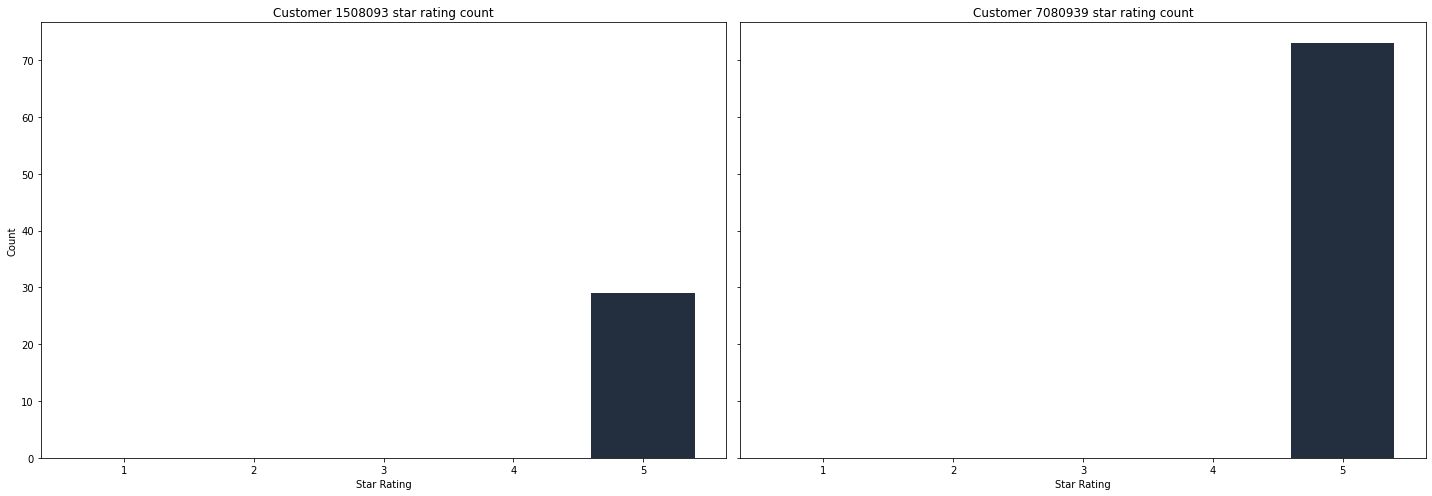

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7), sharey=True)

x = range(1, 6)
iso_val_count = df.loc[df.customer_id ==
                       1508093].star_rating.value_counts().to_dict()
iso_val_count = [iso_val_count[star] if star in iso_val_count else 0
                 for star in x]
ax[0].bar(x, iso_val_count)
ax[0].set_title(f'Customer 1508093 star rating count')
ax[0].set_xlabel('Star Rating')
ax[0].set_ylabel('Count')


iso_val_count = df.loc[df.customer_id ==
                       7080939].star_rating.value_counts().to_dict()
iso_val_count = [iso_val_count[star] if star in iso_val_count else 0
                 for star in x]
ax[1].bar(x, iso_val_count)
ax[1].set_title(f'Customer 7080939 star rating count')
ax[1].set_xlabel('Star Rating')

plt.tight_layout();

In [31]:
df.loc[df.customer_id == 1508093, ['product_title', 'review_body']].sample(8)

,product_title,review_body
74200,Skull Skin Sticker Decal for PS4 Console,excellent
74146,Skins for PS4 Console Decal,excellent
41768,Dual USB Charger Charging Dock Stand for So-ny...,exellent
73627,Star Wars Skins for PS4 Console decal,excellent
73972,U.S. Flag PS4 console sticker skin decal,excellent
73468,Spiderman Protective Vinyl Decal Ps4 Skin Cont...,excellent
73378,Joker Batman Skin Sticker Decal for PS4 Console,excellent
73395,Protective Vinyl Decal Skin Sticker for Ps4 Co...,excellent


In [32]:
df.loc[df.customer_id == 7080939, ['product_title', 'review_body']].sample(8)

,product_title,review_body
128489,JUST DANCE KIDS,just dance kids 1
128398,Just Dance Kids 2014 Wii,just dance kids 2014
128709,Just Dance Disney Party Wii,just dance disney
130027,New Just Dance Kids 2014 (Nintendo Wii U) Musi...,just dance kids 2014
128692,JUST DANCE GREATEST HITS,just dance greatest hits
129990,Tonka Search & Rescue 2,tonka rescue 2
129157,Selected Just Dance Kids Wii By Ubisoft,just dance kids 1
129001,THQ 36408 JEOPARDY [Nintendo DS],jeopardy


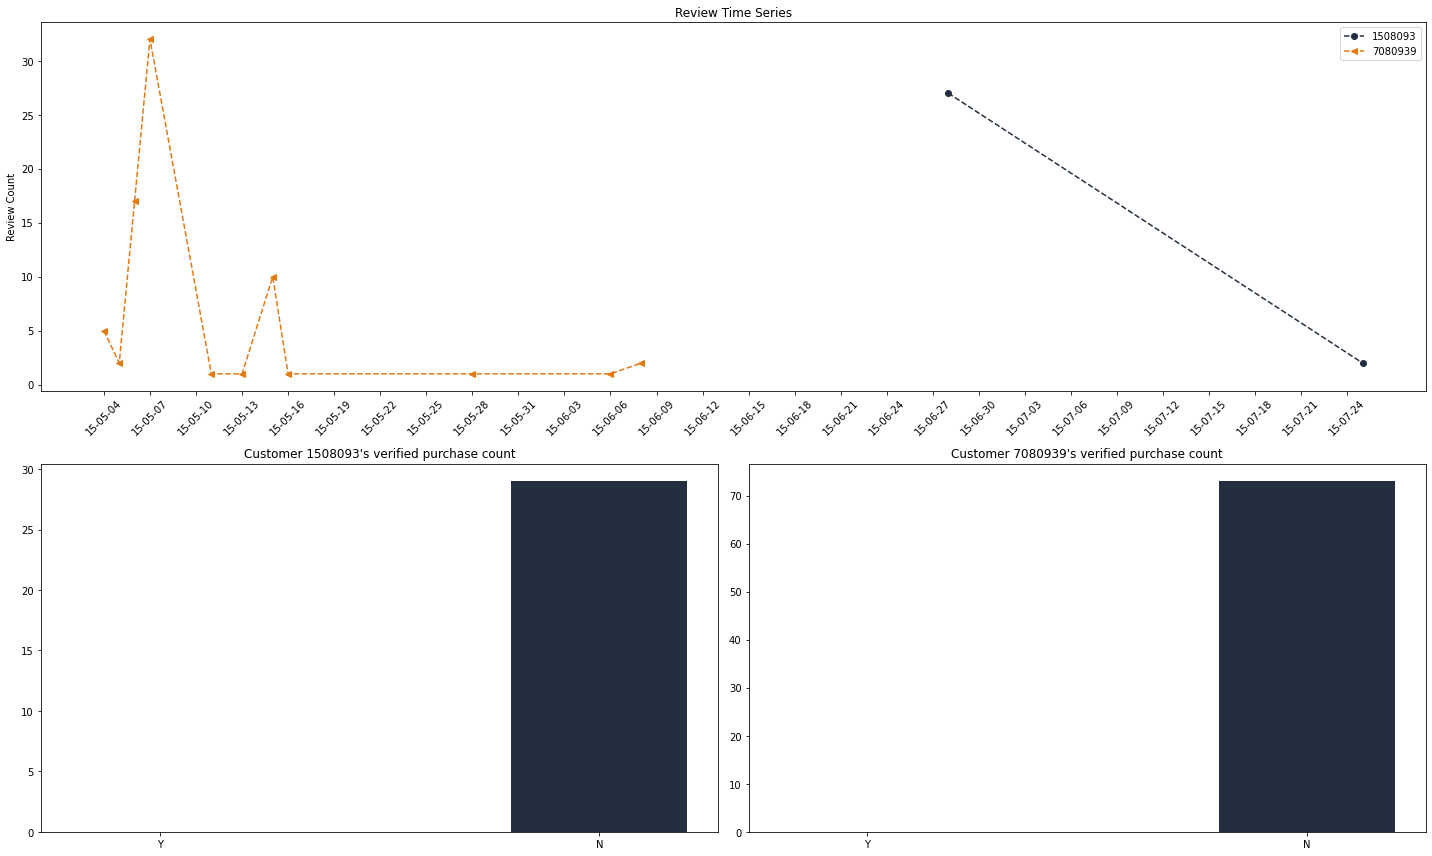

In [86]:
df_ts1 = df.loc[df.customer_id == 1508093,
                ['product_id', 'review_date', 'verified_purchase']].copy()
df_ts1.review_date = pd.to_datetime(df_ts1.review_date)

df_ts2 = df.loc[df.customer_id == 7080939,
                ['product_id', 'review_date', 'verified_purchase']].copy()
df_ts2.review_date = pd.to_datetime(df_ts2.review_date)

ts1 = df_ts1.groupby('review_date')['product_id'].apply(len)
ts2 = df_ts2.groupby('review_date')['product_id'].apply(len)

fig = plt.figure(figsize=(20, 12))

gs = GridSpec(2, 2, figure=fig)

ax0 = fig.add_subplot(gs[0, :])

ax0.plot(ts1, 'o--')
ax0.plot(ts2, '<--')
ax0.legend([1508093, 7080939])

date_range = ts1.append(ts2).sort_index().index
date_range = pd.date_range(start=date_range[0], end=date_range[-1],
                           freq='D')[::3]
date_labels = [x.strftime('%y-%m-%d') for x in date_range]
ax0.set_xticks(date_range)
ax0.set_xticklabels(date_labels, rotation=45)
ax0.set_title('Review Time Series')
ax0.set_ylabel('Review Count')

x = ['Y', 'N']
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])

verif_val_count = df_ts1.verified_purchase.value_counts().to_dict()
verif_val_count = [verif_val_count[val] if val in verif_val_count else 0
                   for val in x]
ax1.bar(x, verif_val_count, width=0.4)
ax1.set_title('Customer 1508093\'s verified purchase count')


verif_val_count = df_ts2.verified_purchase.value_counts().to_dict()
verif_val_count = [verif_val_count[val] if val in verif_val_count else 0
                   for val in x]
ax2.bar(x, verif_val_count, width=0.4)
ax2.set_title('Customer 7080939\'s verified purchase count')

fig.tight_layout()

del df_ts1, df_ts2  # , ts1, ts2

In [36]:
lm = LouvainMethod()
lm_result = lm.fit_transform(customer_giant_G)

6 communities


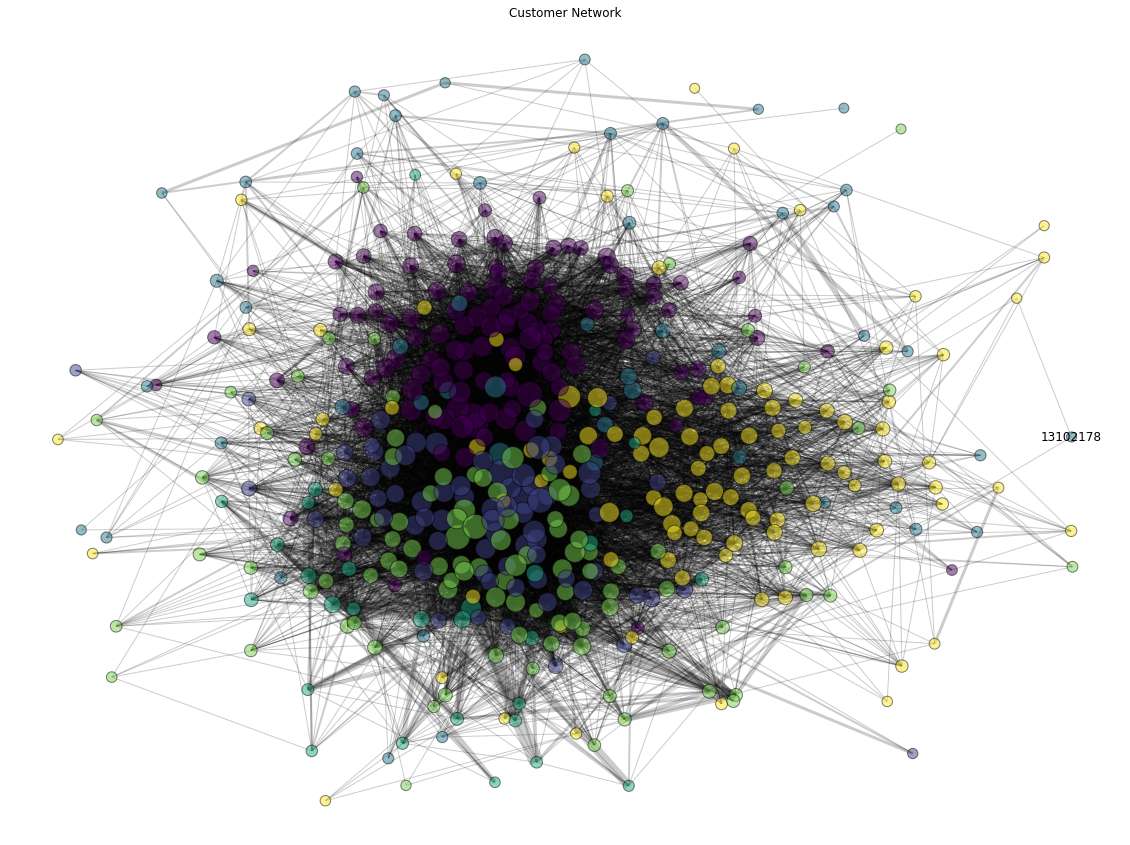

In [37]:
fig, ax = plt.subplots(figsize=(20, 15))
ax.axis("off")

node_size = NodeSizeScaler(
    min_size=100, max_size=800).fit_transform(customer_giant_G)

pos = nx.fruchterman_reingold_layout(customer_giant_G, k=0.7, seed=11)
nx.draw_networkx_nodes(customer_giant_G, pos, node_size=node_size,
                       node_color=lm_result,
                       alpha=0.5,
                       edgecolors='black',
                       ax=ax)
nx.draw_networkx_edges(customer_giant_G, pos, edgelist=edgelist,
                       width=edgewidth, alpha=0.2, ax=ax)

nx.draw_networkx_labels(customer_G, pos, {13102178: '13102178'})

print(f'{len(set(lm_result))} communities')
plt.title('Customer Network')
plt.show()

In [38]:
# Nodes with the lowest degree
lowest_cust_degree = [customer for customer, degree in customer_giant_G.degree
                      if degree <= 10]
df_lowest_degree = df.loc[df.customer_id.isin(lowest_cust_degree)].copy()

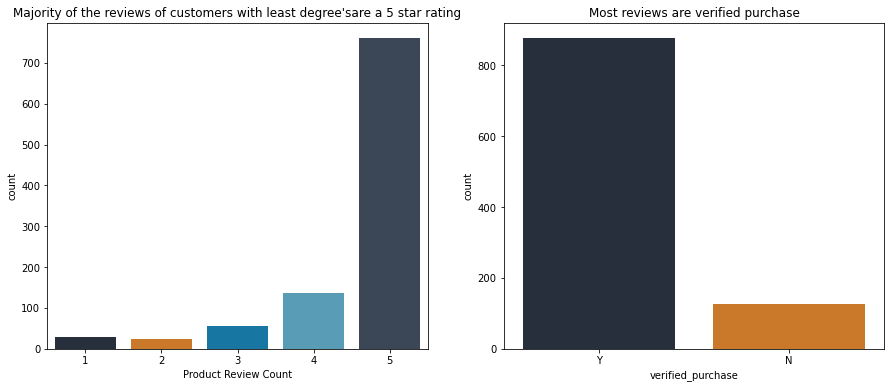

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.countplot(x='star_rating', data=df_lowest_degree, ax=ax[0])
ax[0].set_title(f'Majority of the reviews of customers with least degree\'s'
                'are a 5 star rating')
ax[0].set_xlabel('Product Review Count')

sns.countplot(x='verified_purchase', data=df_lowest_degree, ax=ax[1])
ax[1].set_title('Most reviews are verified purchase')
plt.show()

In [40]:
top5_high_raters = df_lowest_degree.loc[df_lowest_degree.star_rating == 5,
                                        'customer_id'].value_counts().iloc[:5]
df_ts = df_lowest_degree.loc[df_lowest_degree
                             .customer_id.isin(top5_high_raters.index)]

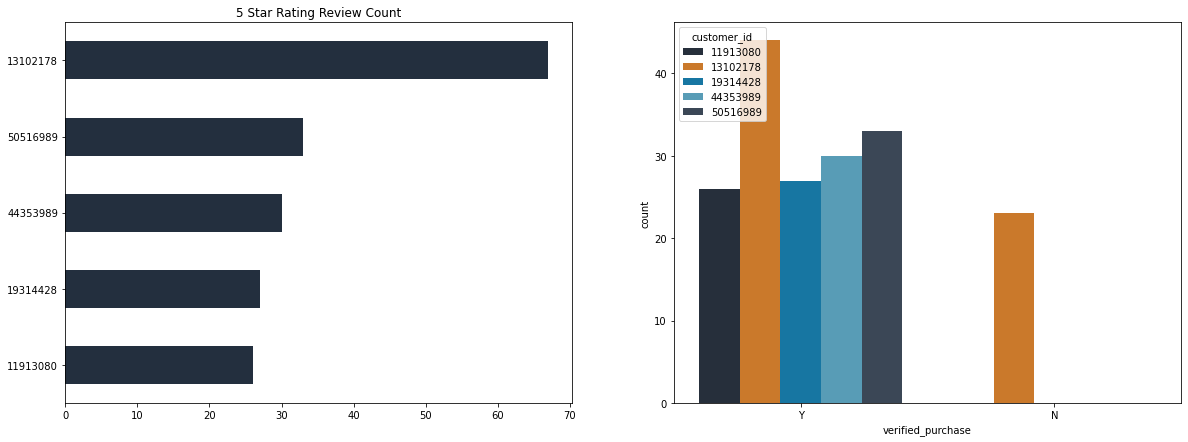

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
top5_high_raters.sort_values(ascending=True).plot.barh(ax=ax[0])
ax[0].set_title('Customer 13102178 has given 5 star reviews 67 products')
ax[0].set_title('5 Star Rating Review Count')

sns.countplot(x='verified_purchase', data=df_ts, hue='customer_id');

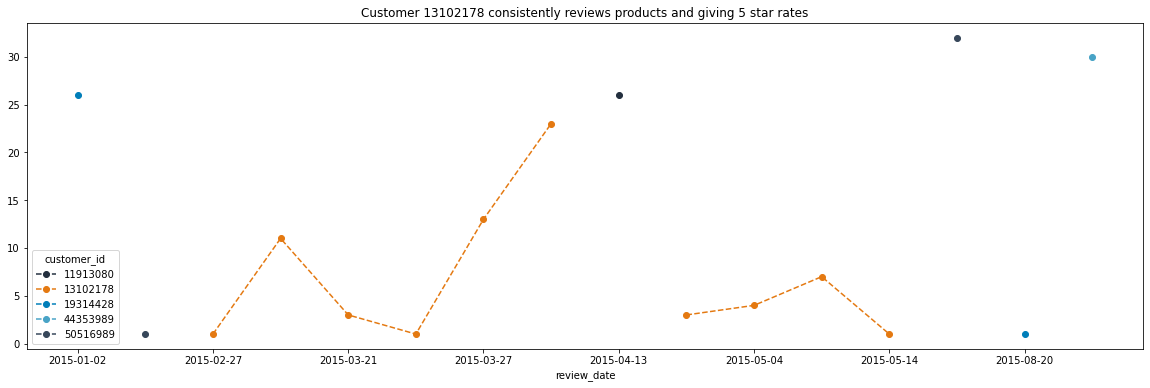

In [42]:

df_ts = (df_ts.groupby(['customer_id', 'review_date'])
         .product_id.apply(len).to_frame().reset_index())
df_ts.rename(columns=dict(product_id='product_count'), inplace=True)
df_ts.sort_values(by='review_date', inplace=True)

date_range = pd.date_range(start=df_ts.review_date.iloc[0],
                           periods=df_ts.shape[0], freq='D')
date_labels = [x.strftime('%y-%m-%d') for x in date_range]

df_ts = df_ts.pivot(index='review_date', values='product_count',
                    columns='customer_id')

fig, ax = plt.subplots(figsize=(20, 6))
df_ts.plot(marker='o', linestyle='--', ax=ax)
ax.set_title('Customer 13102178 consistently reviews products and '
             'giving 5 star rates');
# ax.set_ylim((-2, 33))

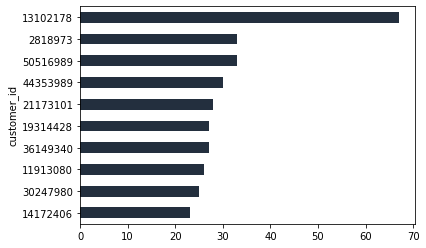

In [43]:
df_lowest_degree.groupby('customer_id').apply(len).sort_values().iloc[-10:].plot.barh();

In [44]:
customer_giant_G.degree(13102178)

2

<AxesSubplot:>

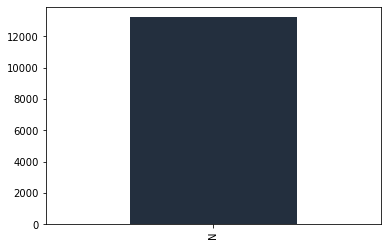

In [45]:
df_top.vine.value_counts().plot.bar()

In [46]:
df_lowest_degree.loc[df_lowest_degree.customer_id==13102178, ['vine', 'review_headline', 'review_body']]

,vine,review_headline,review_body
121131,N,good,Good
122494,N,Good,Good
122617,N,Good,Good
122937,N,Good,Good
123054,N,Good,Good
...,...,...,...
207735,N,Five Stars,Good
208442,N,Five Stars,Good
208531,N,Five Stars,Good
208696,N,Five Stars,Good


In [47]:
df.loc[df.customer_id==9877201, ['vine', 'review_headline', 'review_body']]

,vine,review_headline,review_body
94753,N,Awesome Game,Really enjoyed this game. I have waited years ...
94777,N,Nice,Missed this classic on this awesome system.
95133,N,Nice Find,I missed this classic game. This was my first ...
95476,N,Good Game,I forgot how frantic the action was in this ar...
96580,N,Very Happy,Takes 2 AAA batteries and works like a charm. ...
97177,N,thanks!,Items work as described
97356,N,good find,Glad to have these just need to format them to...
105477,N,Yes!,I've played the PS version for years. Getting ...
106094,N,Very Cool Game,Was really excited to pick up this title after...
106513,N,Enjoying This One for a Second Time,I gave the N64 version of this classic wrestli...


In [48]:
list(customer_giant_G.neighbors(13102178))

[1428221, 9877201]

Investigate per Cluster

    * Distribution of star rating and helpful votes per cluster
    * Check verified purchase per cluster
    

Investigate least degree/centrality nodes (star rating)
    
    * pag yung star rating puro mataas, suspicious
    * pag review halos hindi pinag isipan, suspicious
    * pag ikaw lang bumili, tapos puro 5 star pa yung review mo
    * verified purchase

Investigate highest degree/centrality nodes (sentiment analysis)

    * distribution of star rating

nodes with the least edge = least common reviewed products
nodes with the highest edge = most common reviewed products = 



## Construct the Network

Color code based on 5 rating, scale the size of the node based on number of degrees, change the weight of the links based on prevalence of reviewed products.

## Network Properties

## Centrality Measurements

## Community Detection

# Conclusion

# Recommendation

# Reference